<a href="https://colab.research.google.com/github/autinn/satellite-microplastic-research/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%pip install netCDF4 jinja2


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import datasets



In [20]:
import netCDF4 as nc
import pandas as pd
import numpy as np

file_path = '/Users/autinauyeung/satellite-microplastic-research/satellite-microplastic-research/data/microplastic/cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc'
data = nc.Dataset(file_path)
data.variables.keys()


dict_keys(['lat', 'lon', 'num_mp_samples', 'stddev_mp_samples', 'time', 'mp_concentration'])

In [21]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
num_mp_samples = data.variables['num_mp_samples'][:]
mp_conc = data.variables['mp_concentration'][:]
time = data.variables['time'][:]

In [22]:
print(mp_conc)
print(time)

[[[12866.5048828125 12746.2978515625 12626.0908203125 ...
   12846.7802734375 12853.35546875 12859.9296875]
  [13066.8798828125 12973.7470703125 12880.6142578125 ... 12995.87109375
   13019.541015625 13043.2099609375]
  [13267.255859375 13201.197265625 13135.138671875 ... 13144.9619140625
   13185.7265625 13226.4912109375]
  ...
  [13720.9873046875 -- -- ... 13706.0791015625 13711.048828125
   13716.0185546875]
  [13639.8798828125 -- -- ... 13818.0126953125 13758.634765625
   13699.2568359375]
  [13558.771484375 13665.4248046875 13772.078125 ... 13929.9453125
   13806.220703125 13682.49609375]]]
[17759.5]


In [23]:
# extract mp_concentration from (1,297,1440) to (297,1440)
# mapping the mp_concentration to the corresponding lattitude and longitude
mp_conc_squz = np.squeeze(mp_conc)

# np.meshgrid() create a grid out of two given one-dimensional arrays
# indexing='ij' makes sure the output follows the matrix indexing (row-major ij) / Cartesian indexing ('xy')
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

In [24]:
# .flatten() converts multi-dimensional arrays into 1D array
# .flatten() reshapes 2D lat_grid / lon_grid array into 1D array to be stored in Pandas

print(lat_grid.shape)
print(lat_grid.flatten().shape)

(297, 1440)
(427680,)


In [25]:
df = pd.DataFrame({
    'lat': lat_grid.flatten(),
    'lon': lon_grid.flatten(),
    'mp_conc': mp_conc_squz.flatten()})
df.head()
df.shape

(427680, 3)

Data Cleaning

In [26]:
# check if there are NaN columns
df.isna().sum()

# select rows that contained at least one NaN
df[df.isna().any(axis=1)]

lat     lon  mp_conc
561    -37.0  140.25      NaN
562    -37.0  140.50      NaN
563    -37.0  140.75      NaN
564    -37.0  141.00      NaN
565    -37.0  141.25      NaN
...      ...     ...      ...
427663  37.0  355.75      NaN
427664  37.0  356.00      NaN
427665  37.0  356.25      NaN
427666  37.0  356.50      NaN
427667  37.0  356.75      NaN

[116603 rows x 3 columns]

In [27]:
# drop the rows with NaN and double check for accuracy
df_clean = df.dropna()
df_clean.isna().sum()
df_clean.shape

(311077, 3)

Model Training

System crashed due to high RAM usage during training.

- already dropped NaN values
- can reduce the dataset to only focused on high threshold region (tentatively set to 14000)

In [28]:
# threshold = np.percentile(df['mp_conc'], 90)
# print(threshold)
df_filtered = df[df['mp_conc'] > 14000].copy()
df_filtered


lat     lon       mp_conc
254    -37.0   63.50  14004.700195
255    -37.0   63.75  14014.986328
256    -37.0   64.00  14025.272461
257    -37.0   64.25  14012.548828
261    -37.0   65.25  14001.633789
...      ...     ...           ...
427542  37.0  325.50  14051.513672
427547  37.0  326.75  14119.882812
427548  37.0  327.00  14292.808594
427549  37.0  327.25  14142.757812
427676  37.0  359.00  14053.669922

[27717 rows x 3 columns]

In [29]:
df_filtered.shape

(27717, 3)

In [30]:
# standardisation for data preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(df_filtered[['lat', 'lon','mp_conc']])

In [31]:
%pip install basemap



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [32]:
from mpl_toolkits.basemap import Basemap

In [50]:
def dbscan(df,eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(X)

    plt.figure(figsize=(10, 6))

    # Create a world map projection
    m = Basemap(projection="cyl", resolution="c", llcrnrlat=-40, urcrnrlat=40, llcrnrlon=0, urcrnrlon=360)
    m.drawcoastlines()
    m.fillcontinents(color="lightgray", zorder=0)

    unique_clusters = sorted(df['cluster'].unique())
    color = plt.get_cmap('nipy_spectral', len(unique_clusters))
    num_clusters = len([c for c in unique_clusters if c != -1])
    num_noise = sum(df['cluster'] == -1)

    for cluster in unique_clusters:
        if cluster == -1:
            continue
        cluster_data = df[df['cluster'] == cluster]
        plt.scatter(cluster_data['lon'], cluster_data['lat'], color=color(cluster), label=f'Cluster {cluster}', s=10)

    
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")

   
    print(f"Number of Clusters: {num_clusters}")
    print(f"Number of Noise: {num_noise}")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'DBSCAN Clustering, eps: {eps} & min_samples: {min_samples}')
    plt.show()

In [68]:
def cluster_states(df_fltered):
    cluster_stats = df_filtered.groupby('cluster').agg(
        count=('mp_conc', 'count'),
        mean=('mp_conc', 'mean'),
        std=('mp_conc', 'std'),
        min=('mp_conc', 'min'),
        upper_25=('mp_conc', lambda x: x.quantile(0.25)),
        median=('mp_conc', 'median'),
        lower_75=('mp_conc', lambda x: x.quantile(0.75)),
        max=('mp_conc', 'max'),
        min_lat=('lat', 'min'),
        max_lat=('lat', 'max'),
        min_lon=('lon', 'min'), 
        max_lon=('lon', 'max')
    )
    return cluster_stats

DBSCAN Result: 
Number of Clusters: 8
Number of Noise: 212
Number of Clusters: 8
Number of Noise: 212


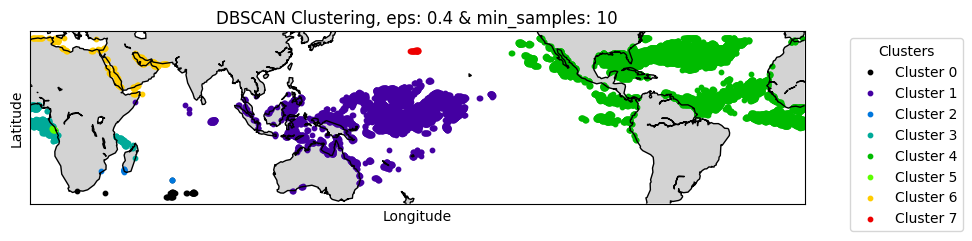

DBSCAN Data: 
         lat     lon       mp_conc  cluster
254    -37.0   63.50  14004.700195        0
255    -37.0   63.75  14014.986328        0
256    -37.0   64.00  14025.272461        0
257    -37.0   64.25  14012.548828        0
261    -37.0   65.25  14001.633789        0
...      ...     ...           ...      ...
427542  37.0  325.50  14051.513672        4
427547  37.0  326.75  14119.882812        4
427548  37.0  327.00  14292.808594        4
427549  37.0  327.25  14142.757812        4
427676  37.0  359.00  14053.669922        4

[27717 rows x 4 columns]
DBSCAN Cluster Data: 


count          mean          std           min      upper_25  \
cluster                                                                 
-1         212  16106.838867  1395.651245  14000.367188  15095.177979   
 0          53  14106.887695   108.965225  14000.809570  14022.763672   
 1       10231  14493.610352   415.904266  14000.156250  14164.384766   
 2          14  14151.689453   112.302414  14019.706055  14069.950195   
 3        1004  14558.872070   455.974213  14002.480469  14187.010742   
 4       15805  14573.958984   516.970032  14000.002930  14191.226562   
 5          10  16316.510742   105.322021  16159.497070  16216.192383   
 6         363  14363.718750   320.596405  14000.233398  14120.048340   
 7          25  14105.816406    67.824959  14000.976562  14043.268555   

               median      lower_75           max  min_lat  max_lat  min_lon  \
cluster                                                                        
-1       16046.282227  17000.463867  20038.683594   -35.00    37.00     0.00   
 0       14066.831055  14145.439453  14470.284180   -37.00   -29.25    22.00   
 1       14385.636719  14722.825684  16644.222656   -34.00    17.25    49.00   
 2       14114.654297  14260.327393  14331.658203   -29.00   -24.00    33.00   
 3       14432.148438  14846.674805  16086.958984   -19.00     6.00     0.00   
 4       14430.348633  14816.305664  18088.759766   -10.50    37.00   223.75   
 5       16348.105469  16387.289795  16455.882812    -5.75    -4.75    10.50   
 6       14277.091797  14535.616211  15603.500000    11.00    37.00     1.25   
 7       14124.817383  14148.196289  14248.421875    30.75    31.25   176.75   

         max_lon  
cluster           
-1        355.50  
 0         76.75  
 1        215.25  
 2         66.25  
 3         49.00  
 4        359.75  
 5         12.00  
 6         63.75  
 7        180.50

In [69]:
eps = 0.4
min_sample = 10

print("DBSCAN Result: ")
dbscan(df_filtered,eps,min_sample)
print("DBSCAN Data: ")
print(df_filtered)
print("DBSCAN Cluster Data: ")
cluster_states(df_filtered)


DBSCAN Result: 
Number of Clusters: 12
Number of Noise: 260
Number of Clusters: 12
Number of Noise: 260


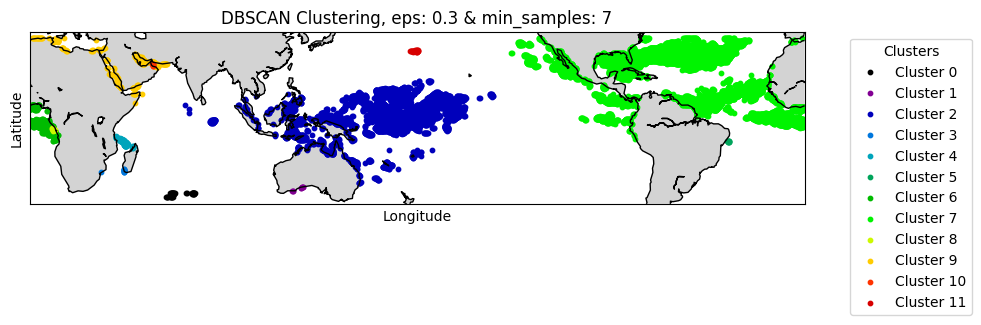

DBSCAN Data: 
         lat     lon       mp_conc  cluster
254    -37.0   63.50  14004.700195        0
255    -37.0   63.75  14014.986328        0
256    -37.0   64.00  14025.272461        0
257    -37.0   64.25  14012.548828        0
261    -37.0   65.25  14001.633789        0
...      ...     ...           ...      ...
427542  37.0  325.50  14051.513672        7
427547  37.0  326.75  14119.882812        7
427548  37.0  327.00  14292.808594        7
427549  37.0  327.25  14142.757812        7
427676  37.0  359.00  14053.669922        7

[27717 rows x 4 columns]
DBSCAN Cluster Data: 


count          mean          std           min      upper_25  \
cluster                                                                 
-1         260  16061.436523  1317.872925  14000.367188  15123.777588   
 0          50  14109.875977   110.850380  14000.809570  14023.390869   
 1           9  14165.260742   119.195992  14006.821289  14085.129883   
 2       10204  14491.583008   411.549561  14000.156250  14164.347656   
 3          12  14167.403320   113.800926  14019.706055  14081.760010   
 4         110  14203.689453   155.382904  14005.117188  14078.532959   
 5           9  14042.963867    35.385826  14008.237305  14017.420898   
 6         889  14599.931641   458.831055  14002.480469  14220.096680   
 7       15773  14571.448242   512.305359  14000.002930  14190.926758   
 8          11  16295.643555   121.547668  16086.958984  16198.413086   
 9         359  14352.360352   306.060577  14000.233398  14119.817871   
 10          6  15647.448242    65.777184  15562.542969  15611.821777   
 11         25  14105.816406    67.824959  14000.976562  14043.268555   

               median      lower_75           max  min_lat  max_lat  min_lon  \
cluster                                                                        
-1       15985.470703  16942.968750  20038.683594   -35.00    37.00     0.00   
 0       14075.119141  14153.931152  14470.284180   -37.00   -34.75    63.50   
 1       14156.807617  14236.238281  14387.863281   -34.00   -32.00   122.00   
 2       14384.992188  14721.579590  16421.716797   -30.50    17.25    72.00   
 3       14133.450195  14271.301270  14331.658203   -25.25   -24.00    33.00   
 4       14171.340820  14301.396729  14707.763672   -14.00    -8.50    40.00   
 5       14034.355469  14059.723633  14110.458984   -11.25   -11.00   324.00   
 6       14503.530273  14902.621094  16032.261719   -11.00     6.00     0.00   
 7       14429.881836  14812.432617  17986.775391   -10.00    37.00   223.75   
 8       16325.648438  16383.813965  16455.882812    -6.00    -4.75    10.50   
 9       14275.477539  14525.210449  15521.585938     7.00    37.00     1.25   
 10      15640.622070  15675.174805  15751.989258    24.00    25.00    57.00   
 11      14124.817383  14148.196289  14248.421875    30.75    31.25   176.75   

         max_lon  
cluster           
-1        355.50  
 0         76.75  
 1        127.25  
 2        215.25  
 3         44.00  
 4         48.00  
 5        325.00  
 6         13.00  
 7        359.75  
 8         12.00  
 9         63.75  
 10        57.50  
 11       180.50

In [70]:
eps = 0.3
min_sample = 7

print("DBSCAN Result: ")
dbscan(df_filtered,eps,min_sample)

print("DBSCAN Data: ")
print(df_filtered)

print("DBSCAN Cluster Data: ")
cluster_states(df_filtered)

DBSCAN Cluster Data: 


count          mean          std           min      upper_25  \
cluster                                                                 
-1         260  16061.436523  1317.872925  14000.367188  15123.777588   
 0          50  14109.875977   110.850380  14000.809570  14023.390869   
 1           9  14165.260742   119.195992  14006.821289  14085.129883   
 2       10204  14491.583008   411.549561  14000.156250  14164.347656   
 3          12  14167.403320   113.800926  14019.706055  14081.760010   
 4         110  14203.689453   155.382904  14005.117188  14078.532959   
 5           9  14042.963867    35.385826  14008.237305  14017.420898   
 6         889  14599.931641   458.831055  14002.480469  14220.096680   
 7       15773  14571.448242   512.305359  14000.002930  14190.926758   
 8          11  16295.643555   121.547668  16086.958984  16198.413086   
 9         359  14352.360352   306.060577  14000.233398  14119.817871   
 10          6  15647.448242    65.777184  15562.542969  15611.821777   
 11         25  14105.816406    67.824959  14000.976562  14043.268555   

               median      lower_75           max  min_lat  max_lat  min_lon  \
cluster                                                                        
-1       15985.470703  16942.968750  20038.683594   -35.00    37.00     0.00   
 0       14075.119141  14153.931152  14470.284180   -37.00   -34.75    63.50   
 1       14156.807617  14236.238281  14387.863281   -34.00   -32.00   122.00   
 2       14384.992188  14721.579590  16421.716797   -30.50    17.25    72.00   
 3       14133.450195  14271.301270  14331.658203   -25.25   -24.00    33.00   
 4       14171.340820  14301.396729  14707.763672   -14.00    -8.50    40.00   
 5       14034.355469  14059.723633  14110.458984   -11.25   -11.00   324.00   
 6       14503.530273  14902.621094  16032.261719   -11.00     6.00     0.00   
 7       14429.881836  14812.432617  17986.775391   -10.00    37.00   223.75   
 8       16325.648438  16383.813965  16455.882812    -6.00    -4.75    10.50   
 9       14275.477539  14525.210449  15521.585938     7.00    37.00     1.25   
 10      15640.622070  15675.174805  15751.989258    24.00    25.00    57.00   
 11      14124.817383  14148.196289  14248.421875    30.75    31.25   176.75   

         max_lon  
cluster           
-1        355.50  
 0         76.75  
 1        127.25  
 2        215.25  
 3         44.00  
 4         48.00  
 5        325.00  
 6         13.00  
 7        359.75  
 8         12.00  
 9         63.75  
 10        57.50  
 11       180.50

Number of Clusters: 12
Number of Noise: 260


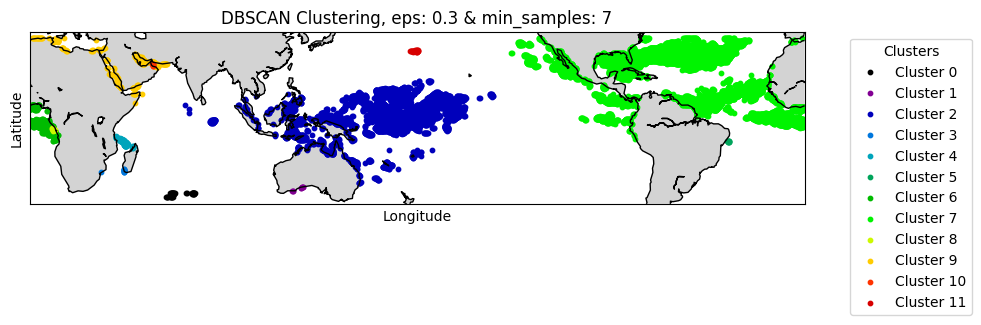

lat     lon       mp_conc  cluster
254    -37.0   63.50  14004.700195        0
255    -37.0   63.75  14014.986328        0
256    -37.0   64.00  14025.272461        0
257    -37.0   64.25  14012.548828        0
261    -37.0   65.25  14001.633789        0
...      ...     ...           ...      ...
427542  37.0  325.50  14051.513672        7
427547  37.0  326.75  14119.882812        7
427548  37.0  327.00  14292.808594        7
427549  37.0  327.25  14142.757812        7
427676  37.0  359.00  14053.669922        7

[27717 rows x 4 columns]

In [64]:
dbscan(df_filtered, 0.3, 7)
df_filtered

In [65]:
cluster_states(df_filtered)

count          mean          std           min      upper_25  \
cluster                                                                 
-1         260  16061.436523  1317.872925  14000.367188  15123.777588   
 0          50  14109.875977   110.850380  14000.809570  14023.390869   
 1           9  14165.260742   119.195992  14006.821289  14085.129883   
 2       10204  14491.583008   411.549561  14000.156250  14164.347656   
 3          12  14167.403320   113.800926  14019.706055  14081.760010   
 4         110  14203.689453   155.382904  14005.117188  14078.532959   
 5           9  14042.963867    35.385826  14008.237305  14017.420898   
 6         889  14599.931641   458.831055  14002.480469  14220.096680   
 7       15773  14571.448242   512.305359  14000.002930  14190.926758   
 8          11  16295.643555   121.547668  16086.958984  16198.413086   
 9         359  14352.360352   306.060577  14000.233398  14119.817871   
 10          6  15647.448242    65.777184  15562.542969  15611.821777   
 11         25  14105.816406    67.824959  14000.976562  14043.268555   

               median      lower_75           max  min_lat  max_lat  min_lon  \
cluster                                                                        
-1       15985.470703  16942.968750  20038.683594   -35.00    37.00     0.00   
 0       14075.119141  14153.931152  14470.284180   -37.00   -34.75    63.50   
 1       14156.807617  14236.238281  14387.863281   -34.00   -32.00   122.00   
 2       14384.992188  14721.579590  16421.716797   -30.50    17.25    72.00   
 3       14133.450195  14271.301270  14331.658203   -25.25   -24.00    33.00   
 4       14171.340820  14301.396729  14707.763672   -14.00    -8.50    40.00   
 5       14034.355469  14059.723633  14110.458984   -11.25   -11.00   324.00   
 6       14503.530273  14902.621094  16032.261719   -11.00     6.00     0.00   
 7       14429.881836  14812.432617  17986.775391   -10.00    37.00   223.75   
 8       16325.648438  16383.813965  16455.882812    -6.00    -4.75    10.50   
 9       14275.477539  14525.210449  15521.585938     7.00    37.00     1.25   
 10      15640.622070  15675.174805  15751.989258    24.00    25.00    57.00   
 11      14124.817383  14148.196289  14248.421875    30.75    31.25   176.75   

         max_lon  
cluster           
-1        355.50  
 0         76.75  
 1        127.25  
 2        215.25  
 3         44.00  
 4         48.00  
 5        325.00  
 6         13.00  
 7        359.75  
 8         12.00  
 9         63.75  
 10        57.50  
 11       180.50

In [43]:
%pip install jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl (12 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
print(df_filtered)

         lat     lon       mp_conc  cluster
254    -37.0   63.50  14004.700195        0
255    -37.0   63.75  14014.986328        0
256    -37.0   64.00  14025.272461        0
257    -37.0   64.25  14012.548828        0
261    -37.0   65.25  14001.633789        0
...      ...     ...           ...      ...
427542  37.0  325.50  14051.513672        4
427547  37.0  326.75  14119.882812        4
427548  37.0  327.00  14292.808594        4
427549  37.0  327.25  14142.757812        4
427676  37.0  359.00  14053.669922        4

[27717 rows x 4 columns]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


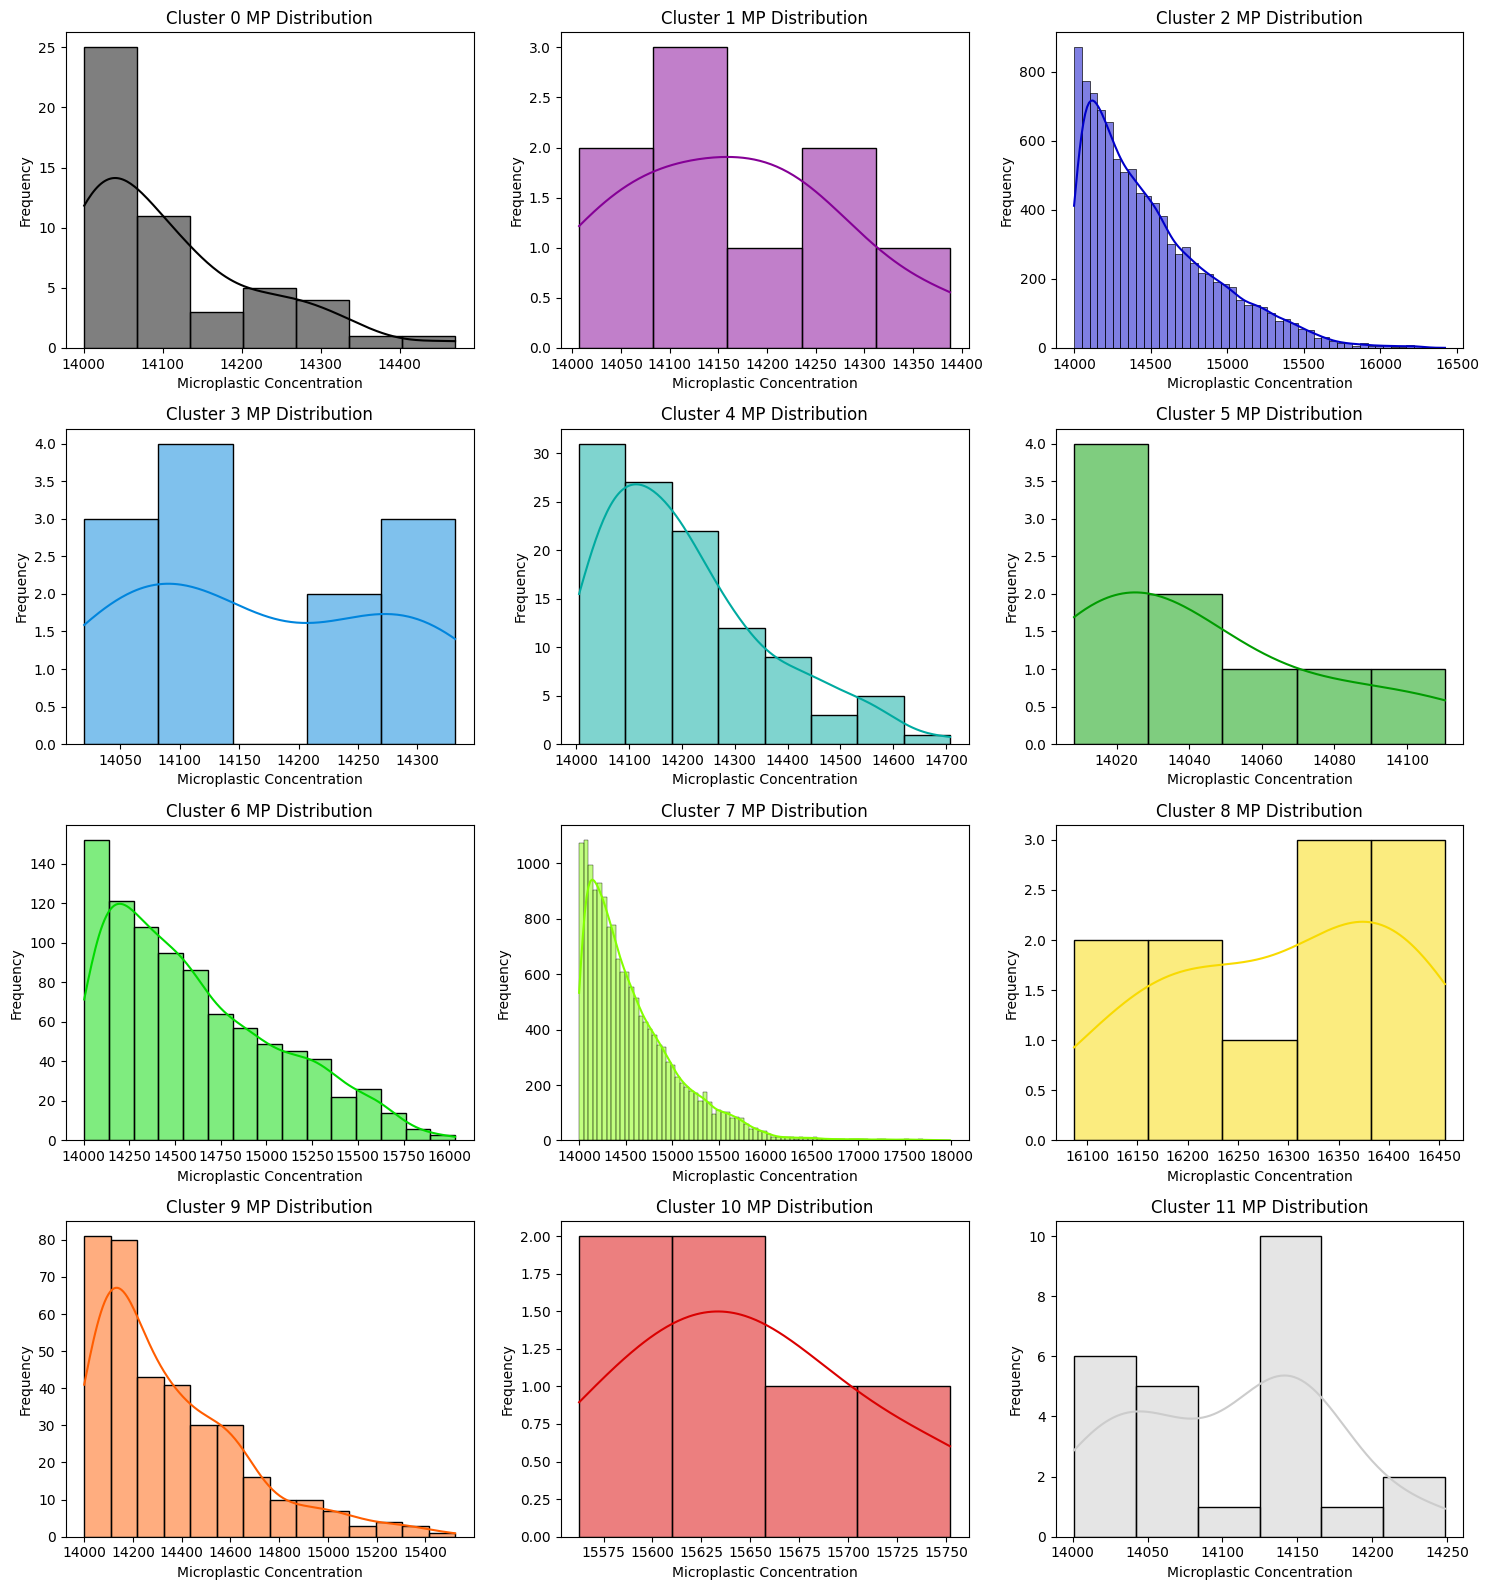

In [ ]:
import seaborn as sns
def histogram(df):
  df = df[df['cluster'] != -1]

  # get unique clusters
  unique_clusters = sorted(df['cluster'].unique())
  print(unique_clusters)

  # define number of subplots
  num_clusters = len(unique_clusters)
  cols = 3
  rows = rows = (num_clusters // cols) + (num_clusters % cols > 0)

  # create subplots
  fig, axes = plt.subplots(rows, cols, figsize=(15, rows*4))
  axes = axes.flatten()

  for i, cluster in enumerate(unique_clusters):

    ax = axes[i]
    subset = df[df['cluster'] == cluster]['mp_conc']

    color = plt.cm.nipy_spectral(i / max(1, len(unique_clusters)-1))
    sns.histplot(subset, kde=True, ax=ax, color=color)
    ax.set_xlabel("Microplastic Concentration")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Cluster {cluster} MP Distribution")

  for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

histogram(df_filtered)

plotting bounding box
1. comput bounding box with min and max latitude and longitude for each cluster
2. plot bounding box
3. overlay cluster points to show spatial distribution

<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


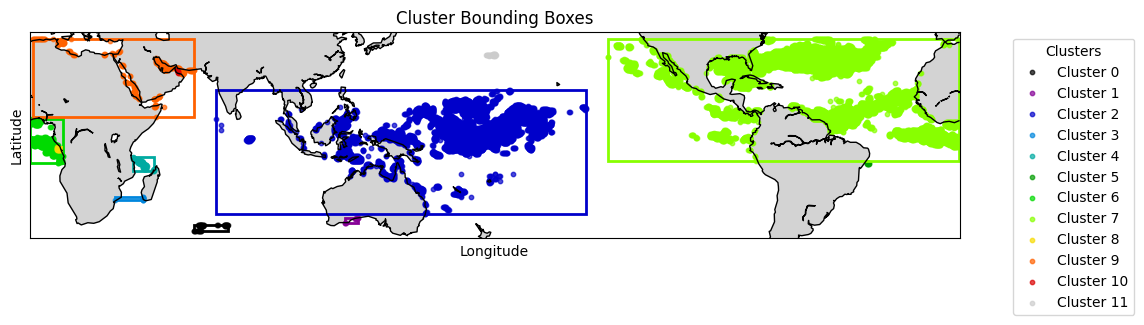

In [ ]:
import matplotlib.patches as patches
def bounding_boxes(df):
  df = df[df['cluster'] != -1]

  # compute bounding box
  bounding_df = df[df['cluster'] != -1].groupby('cluster').agg(
      min_lat = ('lat','min'),
      max_lat = ('lat','max'),
      min_lon = ('lon','min'),
      max_lon = ('lon','max'),
      count = ('cluster','count')
  ).reset_index()


  # initialise world map
  fig, ax = plt.subplots(figsize=(12,6))

  m = Basemap(projection="cyl", resolution="c", llcrnrlat=-40, urcrnrlat=40, llcrnrlon=0, urcrnrlon=360)
  m.drawcoastlines()
  m.fillcontinents(color="lightgray", zorder=0)

  # assign colors to clusters
  unique_clusters = bounding_df['cluster'].unique()
  cmap = plt.get_cmap('nipy_spectral', len(unique_clusters))
  cluster_colors = {cluster: cmap(i/max(1, len(unique_clusters)-1)) for i, cluster in enumerate(unique_clusters)}

  for cluster in unique_clusters:
    cluster_data = df[df['cluster'] == cluster]
    ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])

  for index, row in bounding_df.iterrows():
    cluster_id = row['cluster']
    min_lat, max_lat = row['min_lat'], row['max_lat']
    min_lon, max_lon = row['min_lon'], row['max_lon']
    bbox_color = cluster_colors[cluster_id]

    # create rectangle bounding box
    rect = patches.Rectangle((min_lon, min_lat),
                            max_lon - min_lon,
                            max_lat - min_lat,
                            linewidth=2, edgecolor=bbox_color,fill=False)
    ax.add_patch(rect)

  plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title ('Cluster Bounding Boxes')
  plt.show()


bounding_boxes(df_filtered)

Zoom into each bounding box to look at the microplastic distribution in details

In [ ]:
def plot_cluster_map(df, cluster_id):
  """
    Zooms into a selected cluster and visualizes microplastic concentration distribution.

    - Uses bounding box to filter the cluster region.
    - Scatter plot with colorbar to show concentration levels.

    Parameters:
    - df (DataFrame): Dataset with 'latitude', 'longitude', 'mp_conc', and 'cluster'.
    - cluster_id (int): The cluster to zoom into.

    Output:
    - Scatter plot of microplastic concentration for the selected cluster.
    """
  cluster_bounds = df.groupby('cluster').agg(
      max_lat = ('lat','max'),
      min_lat = ('lat','min'),
      max_lon = ('lon','max'),
      min_lon = ('lon','min'),
      count = ('cluster','count')
  ).reset_index()


  if cluster_id not in cluster_bounds['cluster'].values:
    print(f"Cluster {cluster_id} not found in the dataset.")
    return

  row = cluster_bounds[cluster_bounds['cluster'] == cluster_id]
  min_lon, max_lon = row['min_lon'].values[0], row['max_lon'].values[0]
  min_lat, max_lat = row['min_lat'].values[0], row['max_lat'].values[0]
  count = row['count'].values[0]

  # select points that belong to the clusters
  df_cluster = df[df["cluster"] == cluster_id]
  cluster_stats = df_cluster['mp_conc'].describe()

   # Format stats as a string
  stats_text = (
        f"Cluster {cluster_id} Stats:\n"
        f"Count: {int(cluster_stats['count'])}\n"
        f"Mean: {cluster_stats['mean']:.2f}\n"
        f"Std Dev: {cluster_stats['std']:.2f}\n"
        f"Min: {cluster_stats['min']:.2f}\n"
        f"25%: {cluster_stats['25%']:.2f}\n"
        f"50% (Median): {cluster_stats['50%']:.2f}\n"
        f"75%: {cluster_stats['75%']:.2f}\n"
        f"Max: {cluster_stats['max']:.2f}"
    )

  # decide plotting span
  # Step 1: Compute lat/lon span
  lat_span = max_lat - min_lat
  lon_span = max_lon - min_lon

  # Step 2: Expand bounds using percentage (10% of current range)
  expand_ratio = 0.20  # Adjust this for more or less padding

  lat_expand = lat_span * expand_ratio
  lon_expand = lon_span * expand_ratio

  # Create a world map projection
  fig, ax = plt.subplots(figsize=(12,6))
  m = Basemap(projection="cyl", resolution="c", llcrnrlat=min_lat - lat_expand, urcrnrlat=max_lat + lat_expand, llcrnrlon=min_lon - lon_expand, urcrnrlon=max_lon + lon_expand, ax=ax)
  m.drawcoastlines()
  m.fillcontinents(color="lightgray", zorder=0)


  scatter = plt.scatter(df_cluster['lon'], df_cluster['lat'], c=df_cluster['mp_conc'], cmap='viridis', s=15, alpha=0.7)
  cbar = plt.colorbar(scatter, ax=ax)
  cbar.set_label('Microplastic Concentration')

  ax.text(
      min_lon + (max_lon - min_lon) * 0.85,  # 85% from left
      min_lat + (max_lat - min_lat) * 0.9,
      f"Count: {count}",
      fontsize=10, color='black',
      bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
  )
  plt.figtext(
      0.1, -0.05,
      stats_text, ha="left", fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

  plt.xlim(min_lon, max_lon)
  plt.ylim(min_lat, max_lat)
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title(f'Microplastic Concentration in Cluster {cluster_id}')
  plt.show()


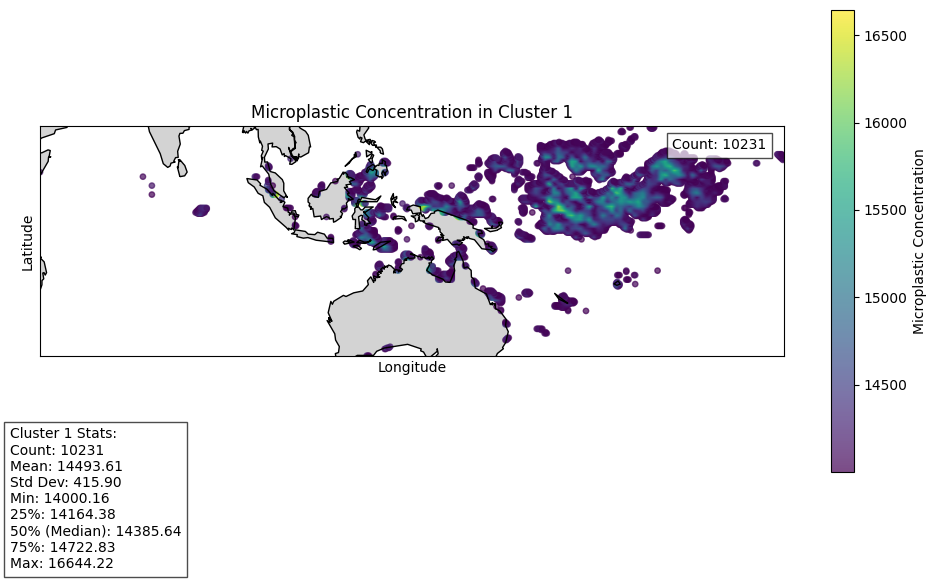

In [ ]:
plot_cluster_map(df_filtered, 1)

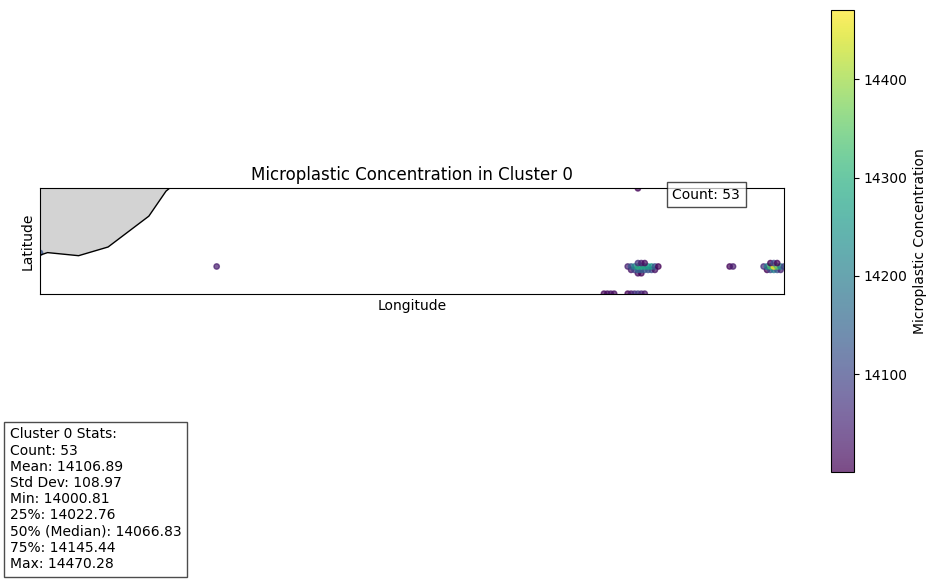

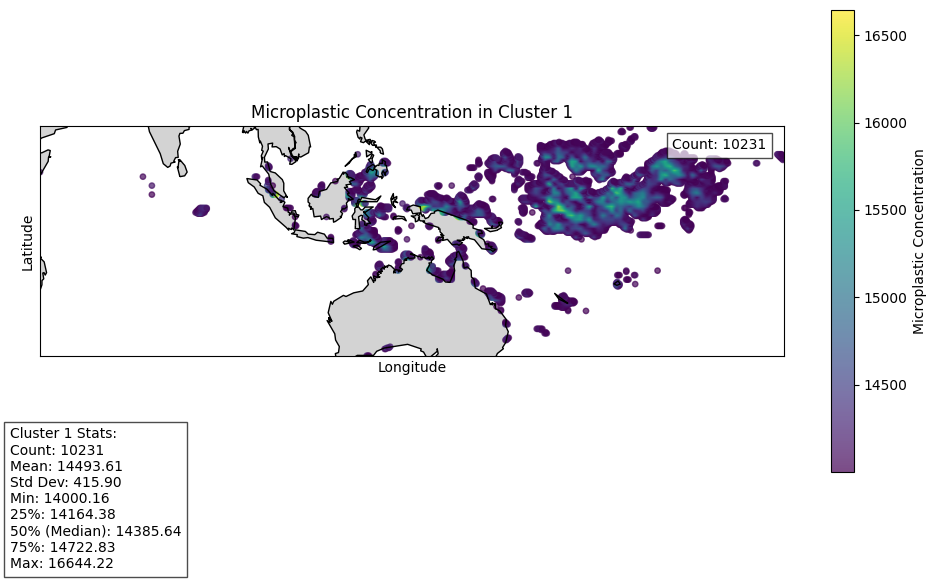

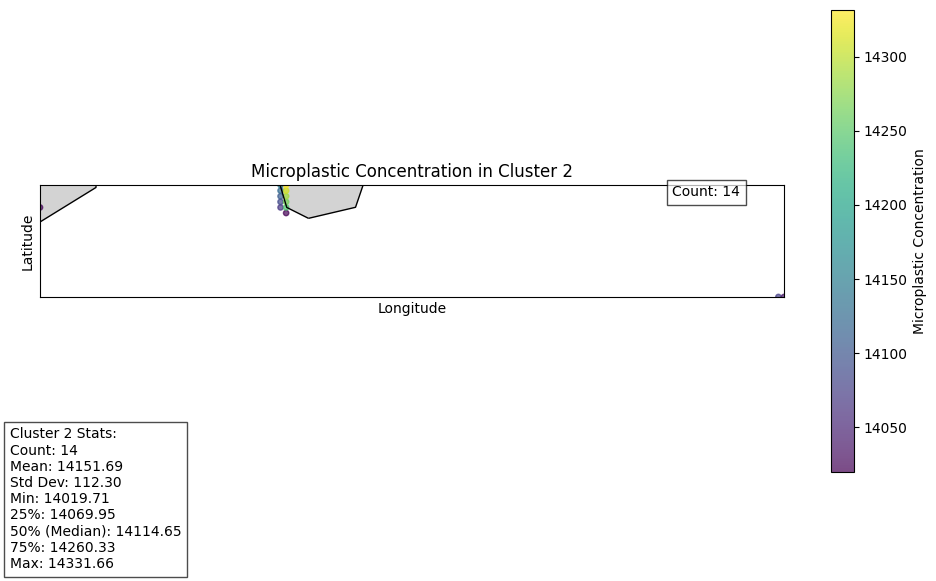

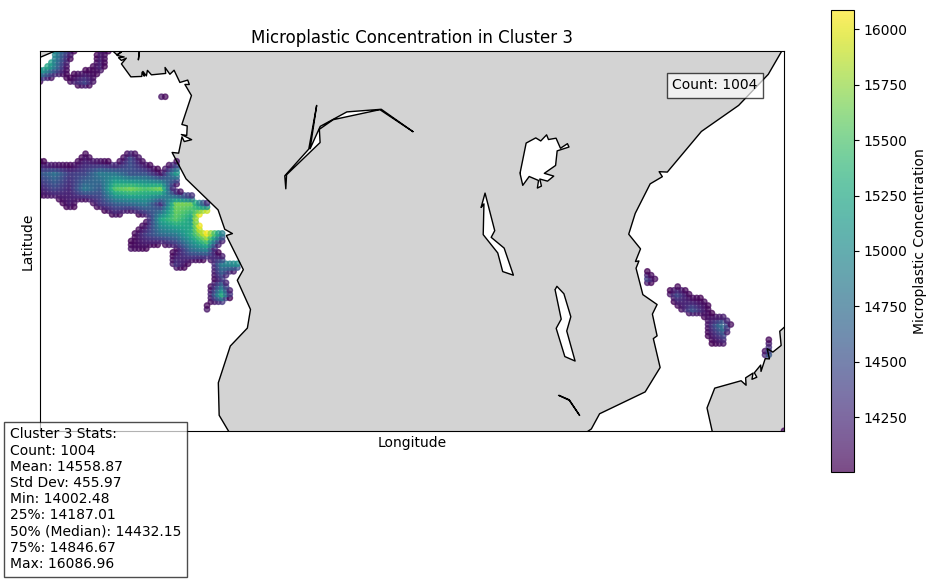

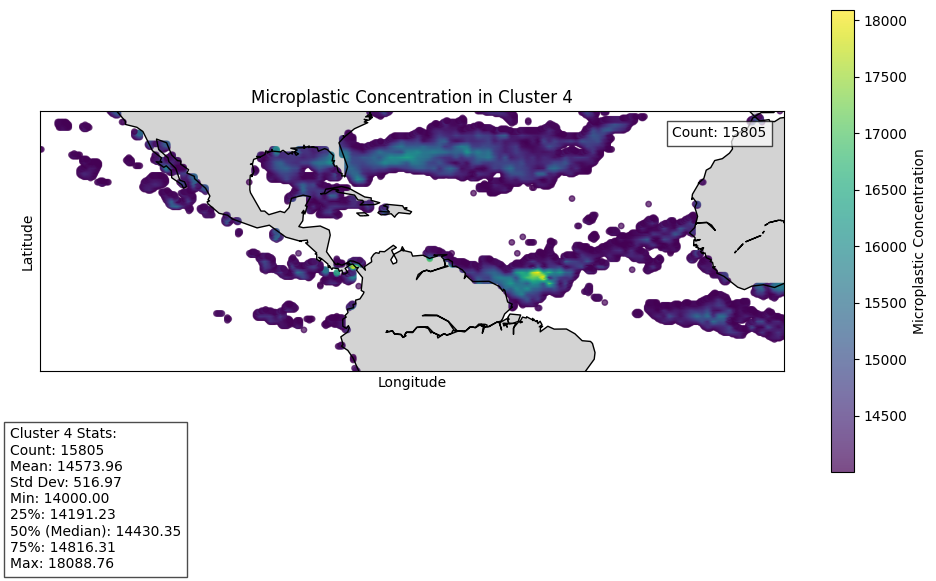

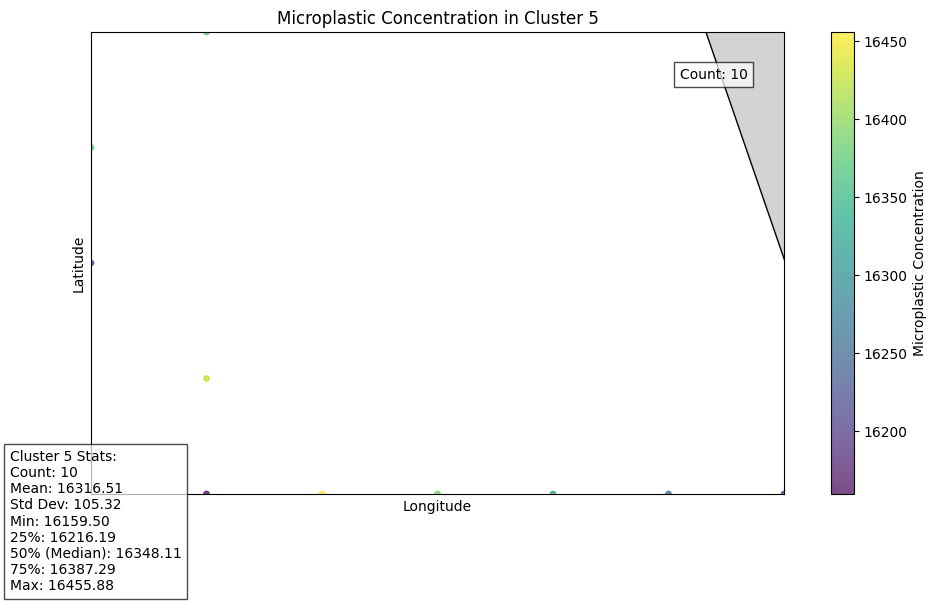

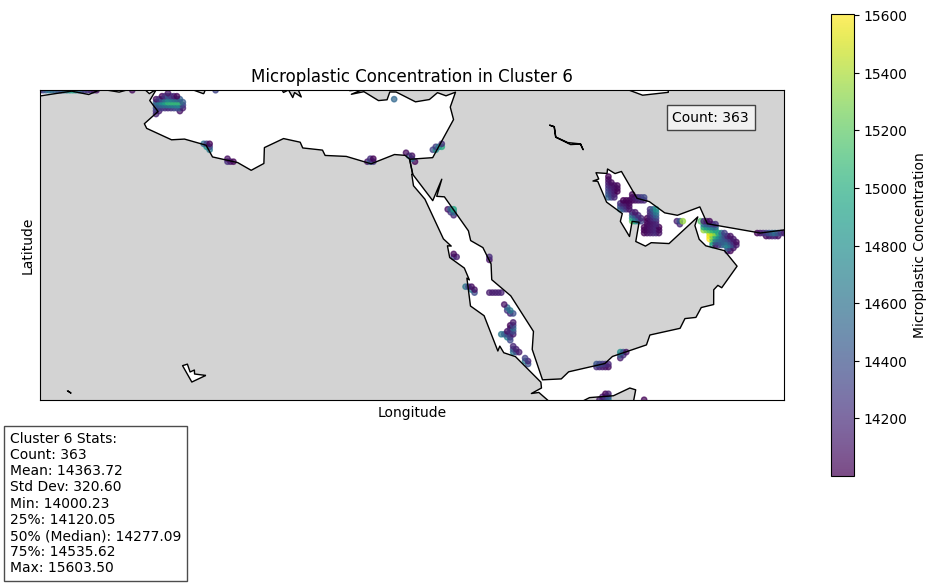

In [ ]:
for i in range (df_filtered['cluster'].max()):
  plot_cluster_map(df_filtered, i)

DBSCAN Documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Run Experiments for hyperparameter tuning
iterate on different eps and min_samples combinations

<ipython-input-17-a85a9a175113>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


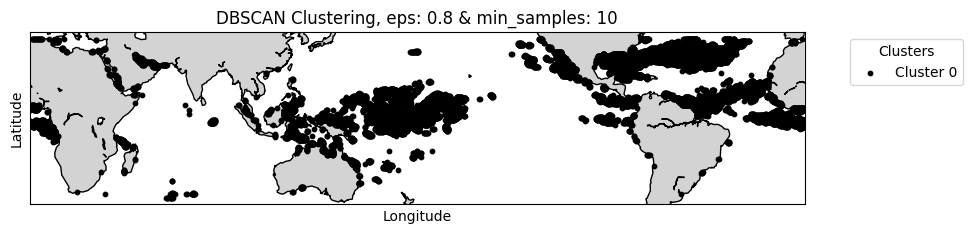

In [ ]:
dbscan(df_filtered,0.8,10)

In [ ]:
eps = [0.2,0.3]
min_samples = [3,4]

In [ ]:
def tune_dbscan(df, eps, min_samples):
  num_rows = len(eps)
  num_cols = len(min_samples)
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*3))
  axes = axes.flatten()

  results = []

  for i, ep in enumerate(eps):
    for j, min_sample in enumerate(min_samples):
      # run DBSCAN
      df_copy = df.copy()
      dbscan = DBSCAN(eps=ep, min_samples=min_sample)
      scaler = StandardScaler()
      X = scaler.fit_transform(df_copy[['lat', 'lon','mp_conc']])
      df_copy['cluster'] = dbscan.fit_predict(X)

      unique_clusters = sorted(df_copy['cluster'].unique())
      num_clusters = len([c for c in unique_clusters if c != -1])
      num_noise = sum(df_copy['cluster'] == -1)

      results.append((ep, min_sample, num_clusters, num_noise))

      # plot on the right axis
      ax = axes[i * num_cols + j]
      m = Basemap(projection="cyl", resolution="c", ax=ax,
                        llcrnrlat=-40, urcrnrlat=40, llcrnrlon=0, urcrnrlon=360)
      m.drawcoastlines()
      m.fillcontinents(color="lightgray", zorder=0)
      color = plt.get_cmap('nipy_spectral', len(unique_clusters))

      for cluster in unique_clusters:
        if cluster == -1:
          continue
        cluster_data = df_copy[df_copy['cluster'] == cluster]
        ax.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)

      ax.set_title(f'eps = {ep}, min_samples = {min_sample}')
      ax.set_xlabel('Longitude')
      ax.set_ylabel('Latitude')

      ax.text(0.95, 0.95,
              f"Clusters: {num_clusters} \nNoise: {num_noise}",
              transform=ax.transAxes, fontsize=9, color='black',
              bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),
              ha='right', va='top')

  # hide additional plots
  for idx in range(len(eps) * len(min_samples), len(axes)):
        axes[idx].axis("off")

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  return results

<ipython-input-41-99d5803a8427>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)
<ipython-input-41-99d5803a8427>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)
<ipython-input-41-99d5803a8427>:36: UserWarning: *c* a

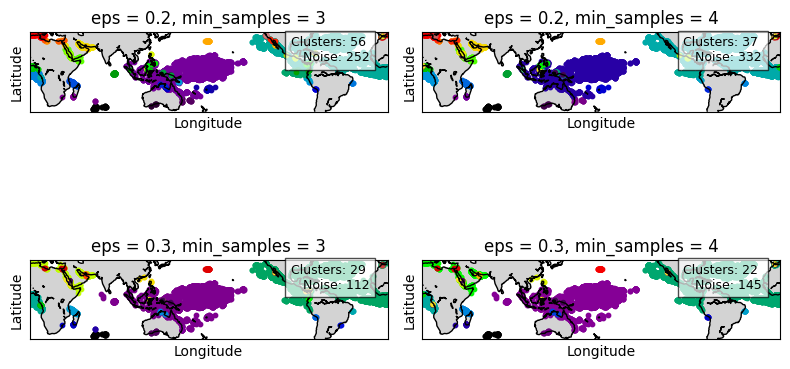

[(0.2, 3, 56, 252), (0.2, 4, 37, 332), (0.3, 3, 29, 112), (0.3, 4, 22, 145)]

In [ ]:
tune_dbscan(df_filtered, eps, min_samples)

In [ ]:
eps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
min_samples = [3,4,5,6,7,8,9,10]

<ipython-input-41-99d5803a8427>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)
<ipython-input-41-99d5803a8427>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)
<ipython-input-41-99d5803a8427>:36: UserWarning: *c* a

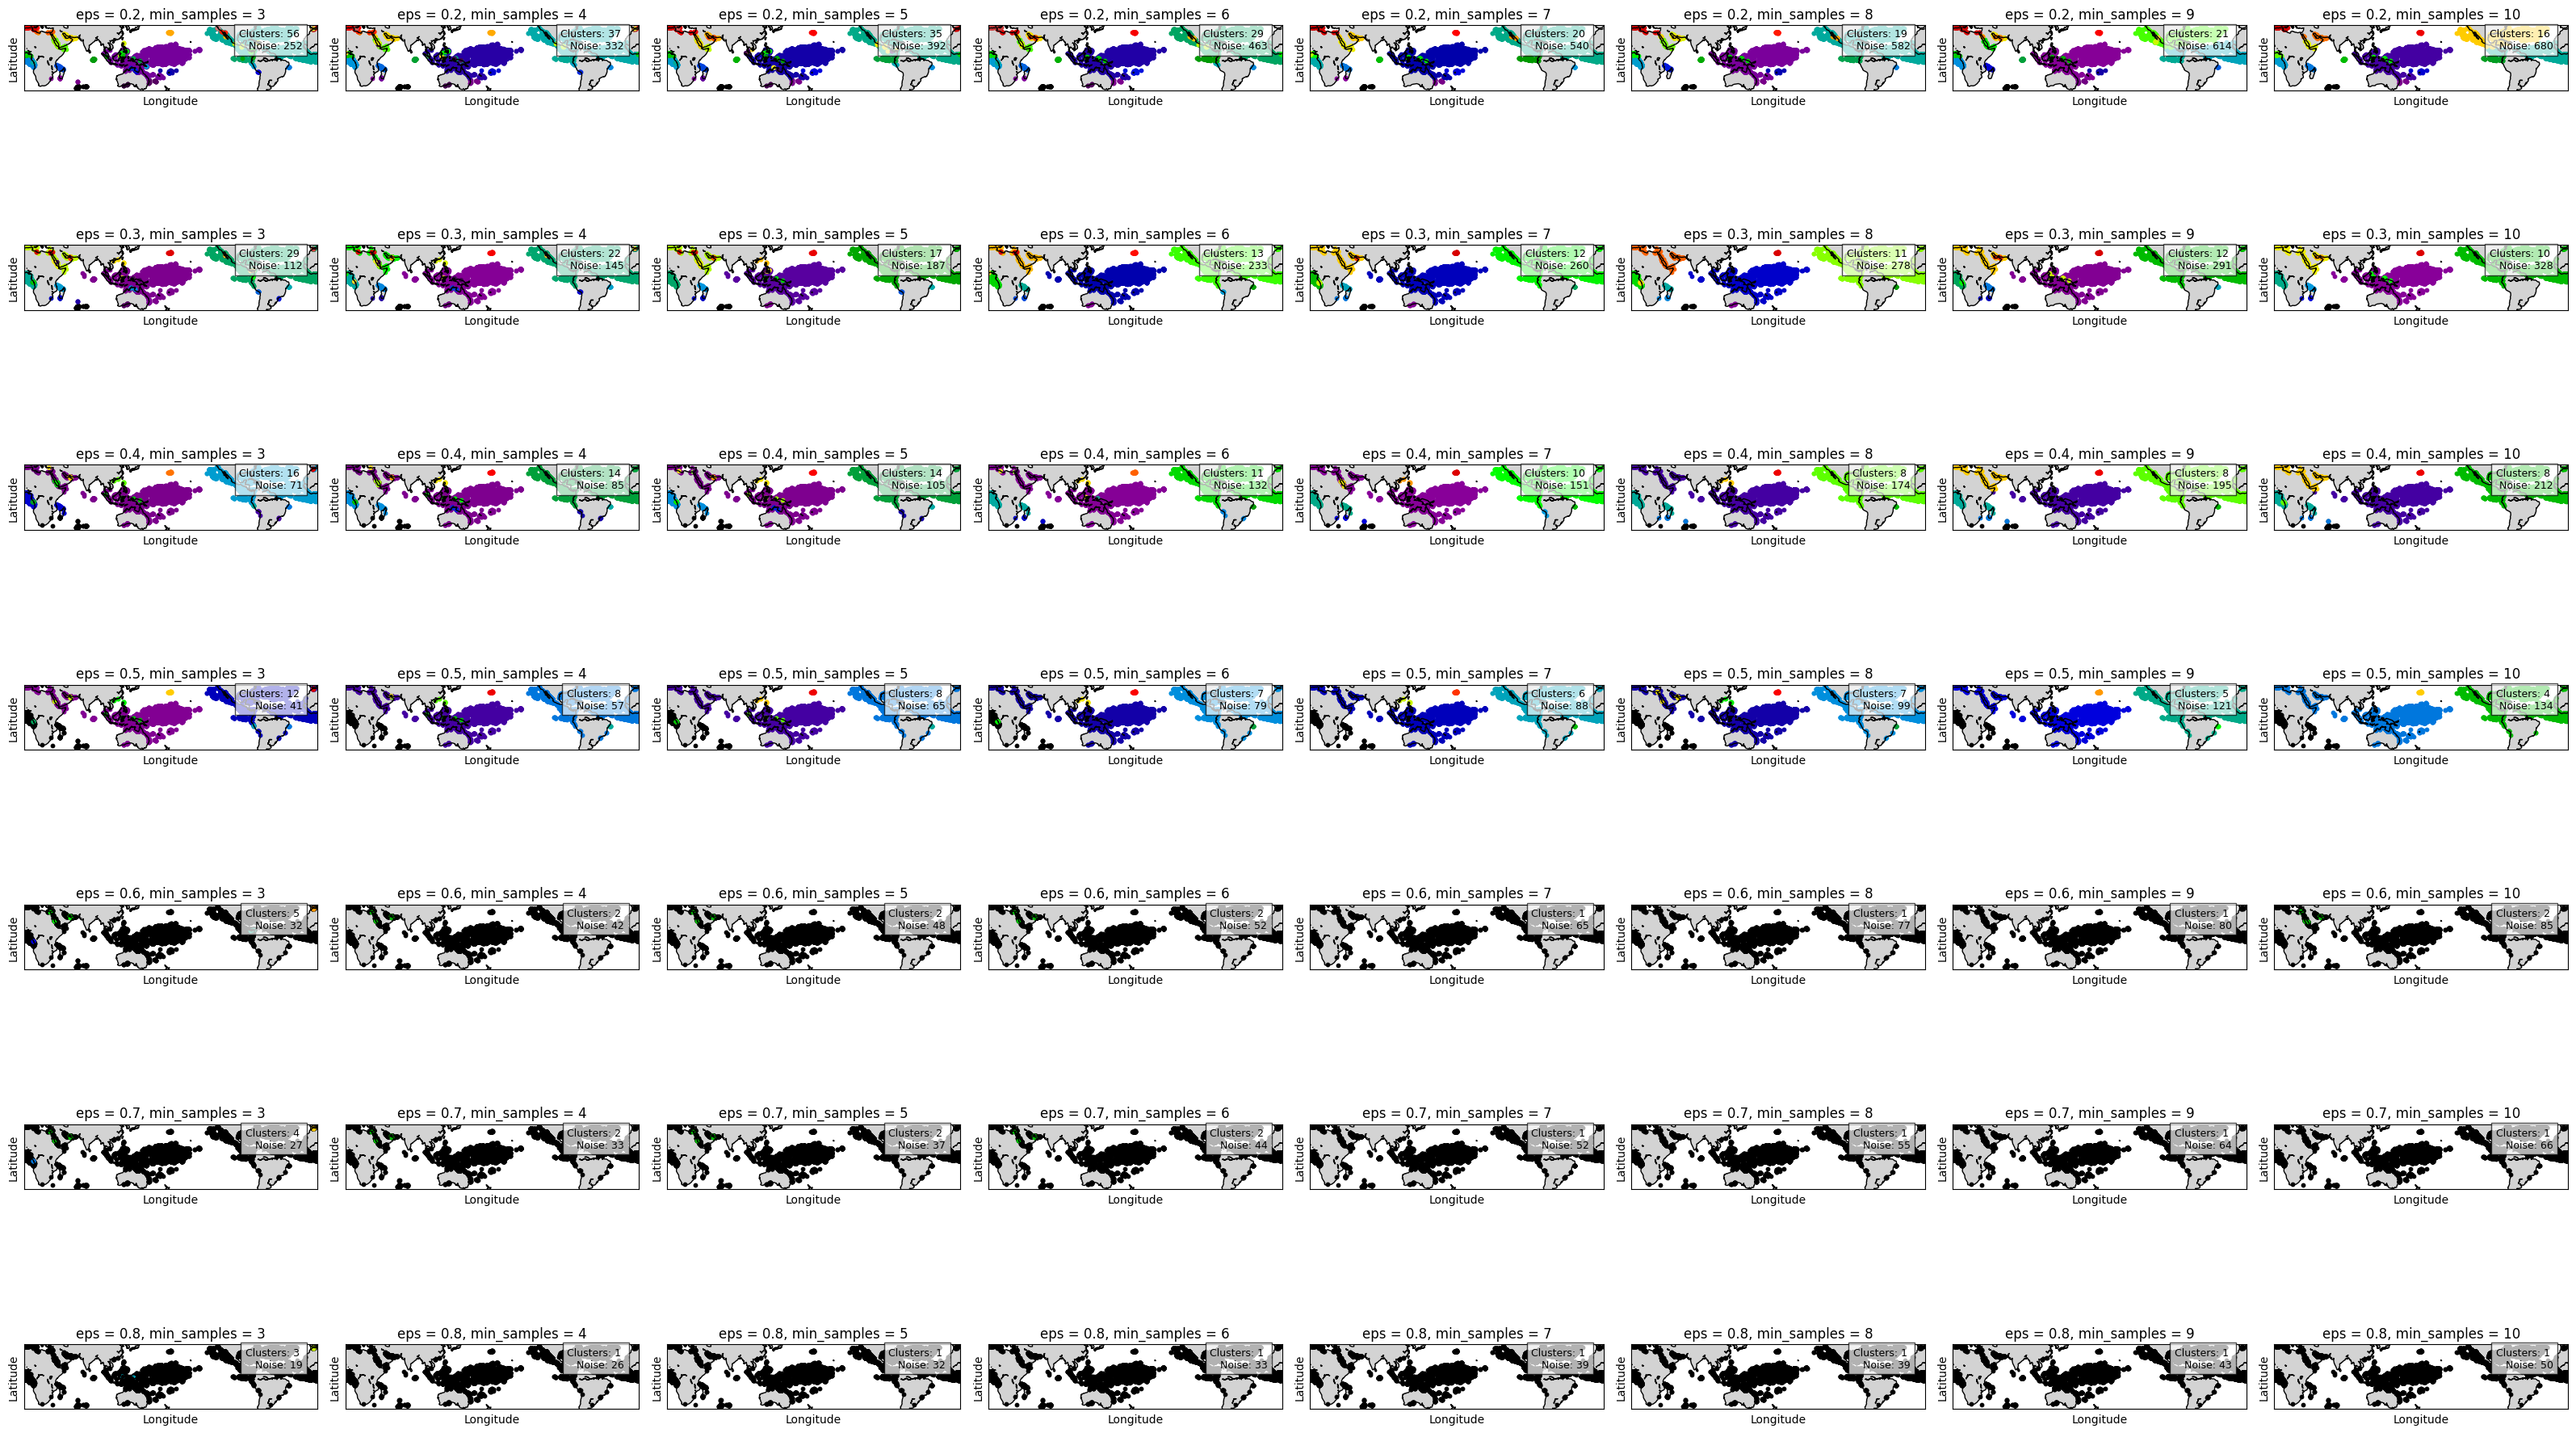

[(0.2, 3, 56, 252),
 (0.2, 4, 37, 332),
 (0.2, 5, 35, 392),
 (0.2, 6, 29, 463),
 (0.2, 7, 20, 540),
 (0.2, 8, 19, 582),
 (0.2, 9, 21, 614),
 (0.2, 10, 16, 680),
 (0.3, 3, 29, 112),
 (0.3, 4, 22, 145),
 (0.3, 5, 17, 187),
 (0.3, 6, 13, 233),
 (0.3, 7, 12, 260),
 (0.3, 8, 11, 278),
 (0.3, 9, 12, 291),
 (0.3, 10, 10, 328),
 (0.4, 3, 16, 71),
 (0.4, 4, 14, 85),
 (0.4, 5, 14, 105),
 (0.4, 6, 11, 132),
 (0.4, 7, 10, 151),
 (0.4, 8, 8, 174),
 (0.4, 9, 8, 195),
 (0.4, 10, 8, 212),
 (0.5, 3, 12, 41),
 (0.5, 4, 8, 57),
 (0.5, 5, 8, 65),
 (0.5, 6, 7, 79),
 (0.5, 7, 6, 88),
 (0.5, 8, 7, 99),
 (0.5, 9, 5, 121),
 (0.5, 10, 4, 134),
 (0.6, 3, 5, 32),
 (0.6, 4, 2, 42),
 (0.6, 5, 2, 48),
 (0.6, 6, 2, 52),
 (0.6, 7, 1, 65),
 (0.6, 8, 1, 77),
 (0.6, 9, 1, 80),
 (0.6, 10, 2, 85),
 (0.7, 3, 4, 27),
 (0.7, 4, 2, 33),
 (0.7, 5, 2, 37),
 (0.7, 6, 2, 44),
 (0.7, 7, 1, 52),
 (0.7, 8, 1, 55),
 (0.7, 9, 1, 64),
 (0.7, 10, 1, 66),
 (0.8, 3, 3, 19),
 (0.8, 4, 1, 26),
 (0.8, 5, 1, 32),
 (0.8, 6, 1, 33),
 (0.8, 7, 1,

In [ ]:
tune_dbscan(df_filtered, eps, min_samples)

In [ ]:
eps = [0.2,0.3]
min_samples = [3,4,5,6,7,8,9,10]

<ipython-input-69-a85a9a175113>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


Number of Clusters: 12
Number of Noise: 260


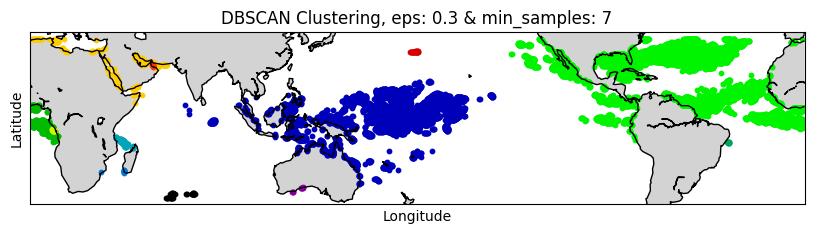

In [ ]:
dbscan(df_filtered,0.3,7)

<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


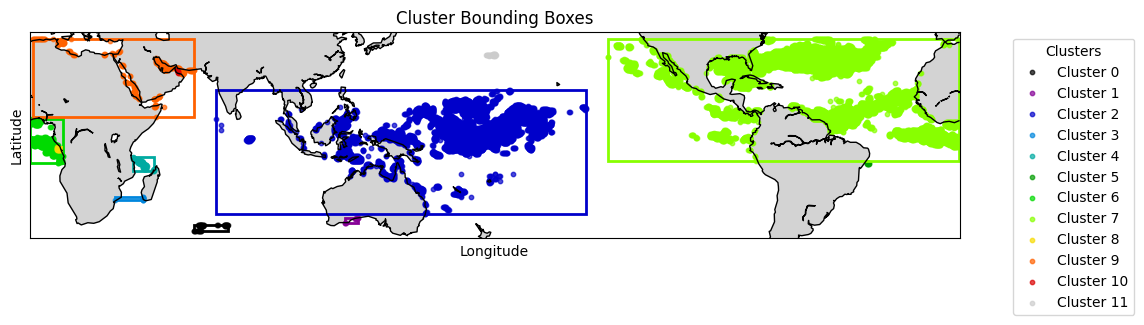

In [ ]:
bounding_boxes(df_filtered)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


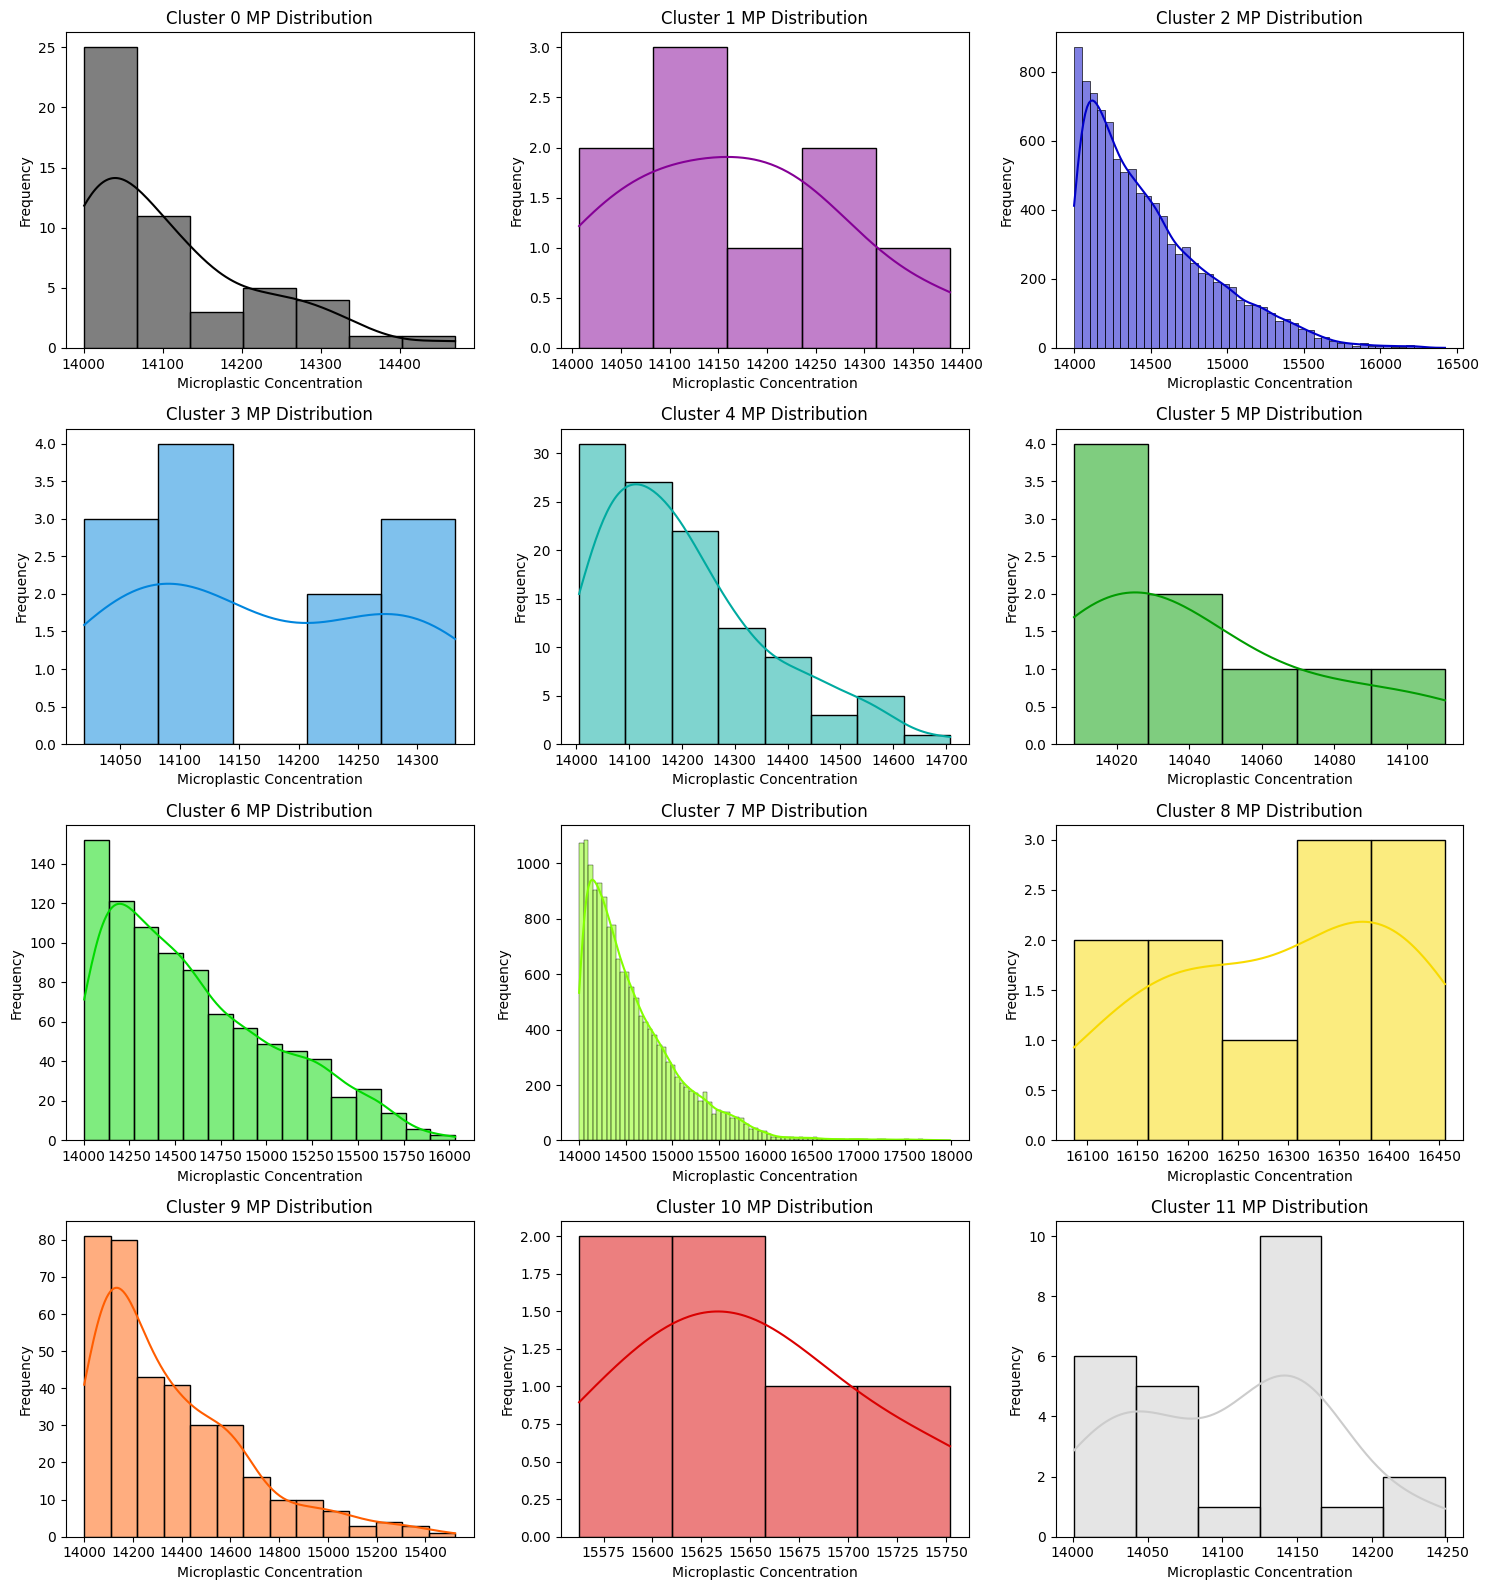

In [ ]:
histogram(df_filtered)

<ipython-input-69-a85a9a175113>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


Number of Clusters: 56
Number of Noise: 252


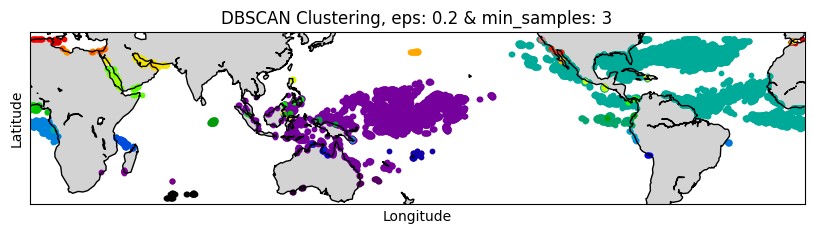

<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


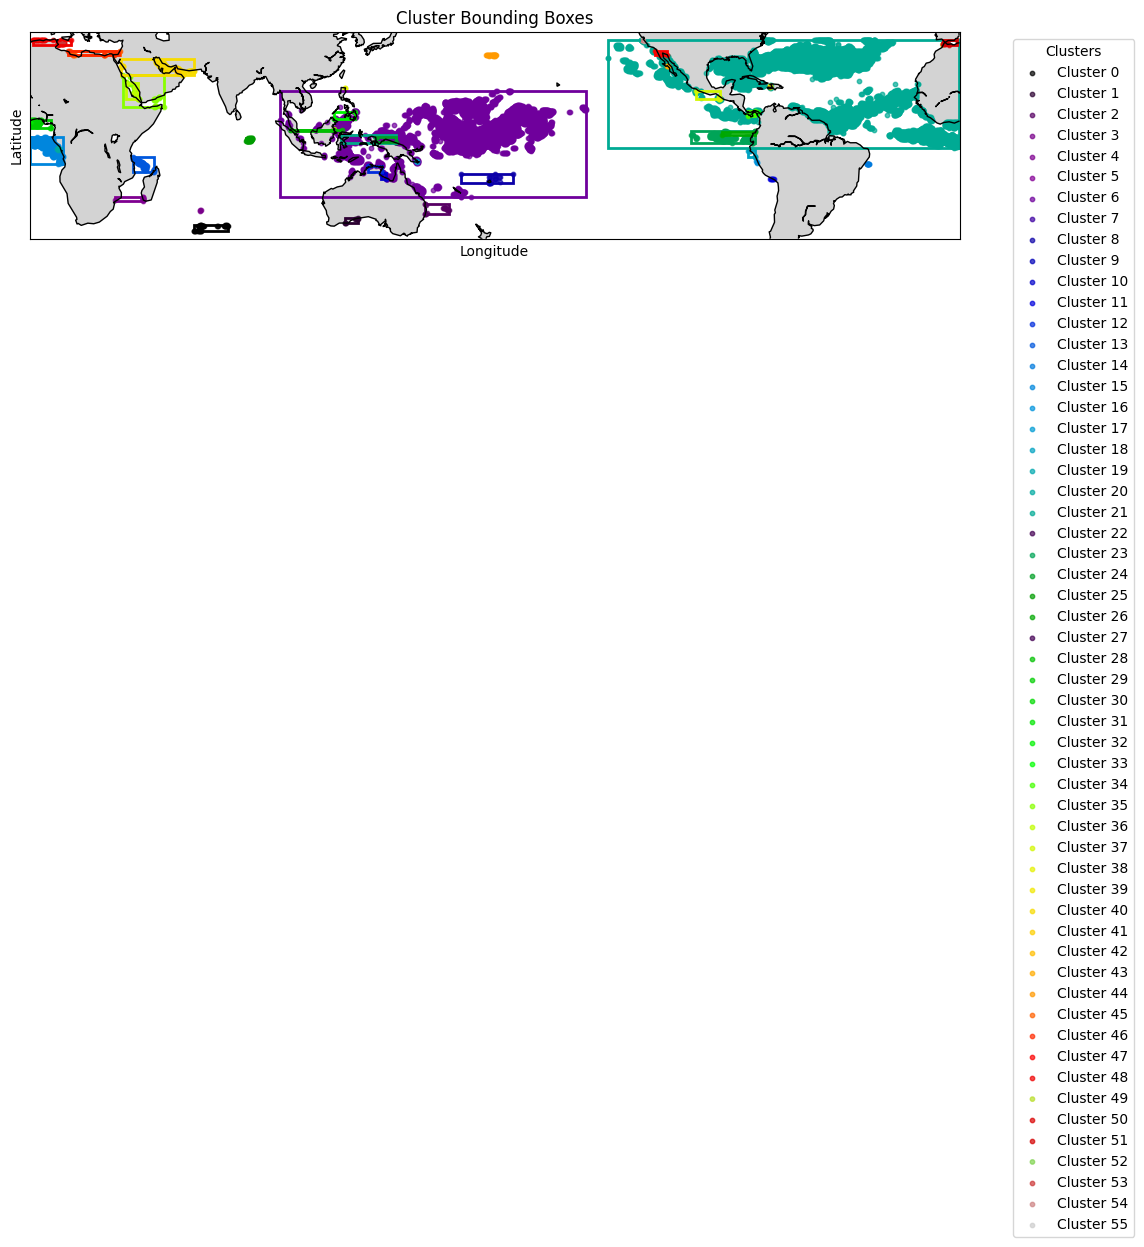

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]


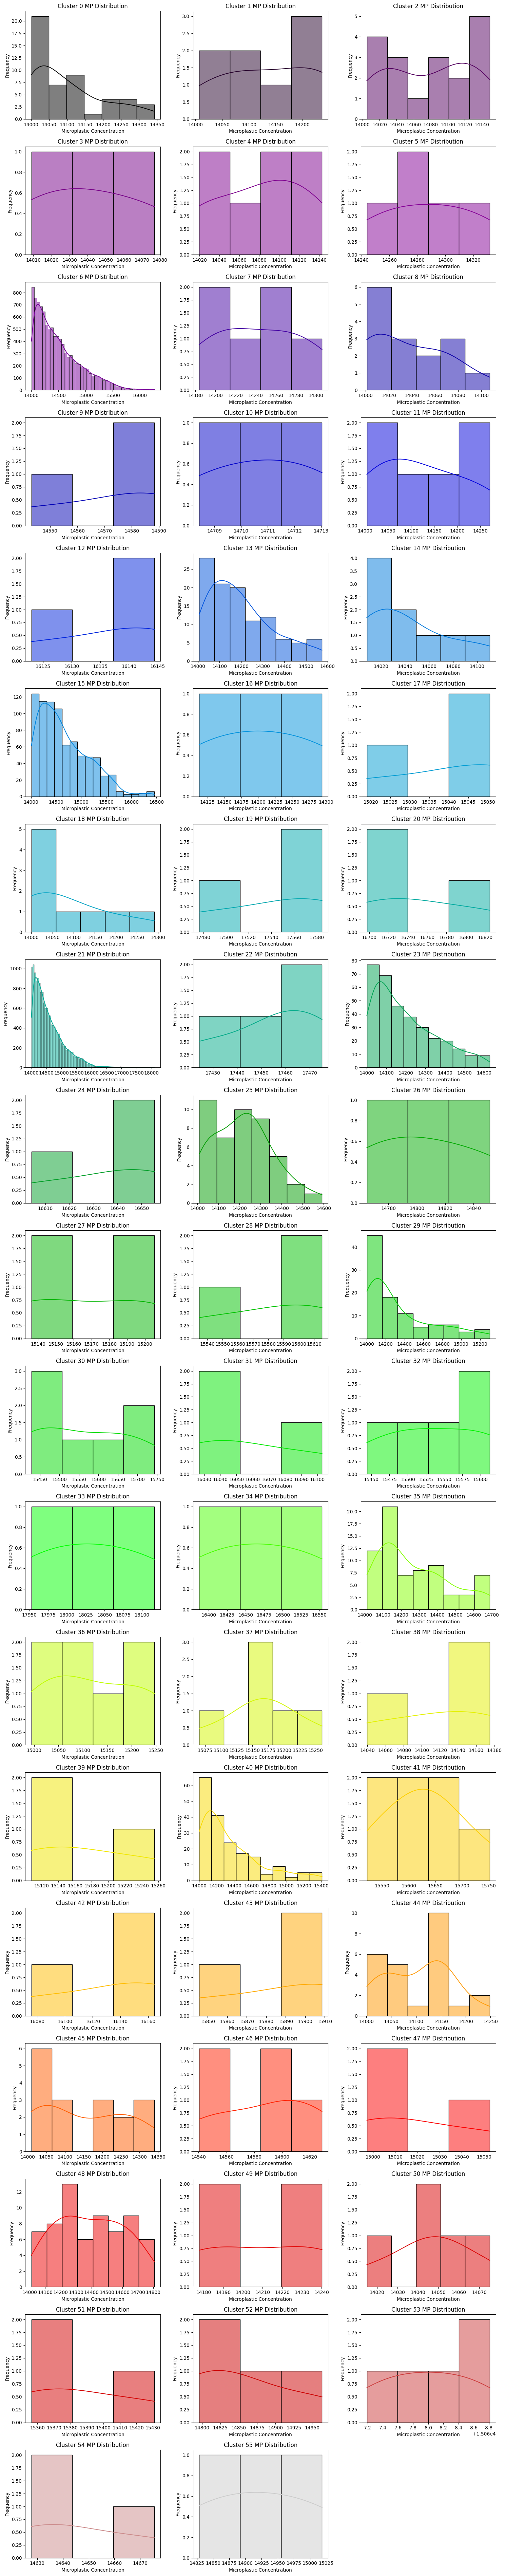

In [ ]:
dbscan(df_filtered, 0.2, 3)
bounding_boxes(df_filtered)
histogram(df_filtered)

<ipython-input-69-a85a9a175113>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


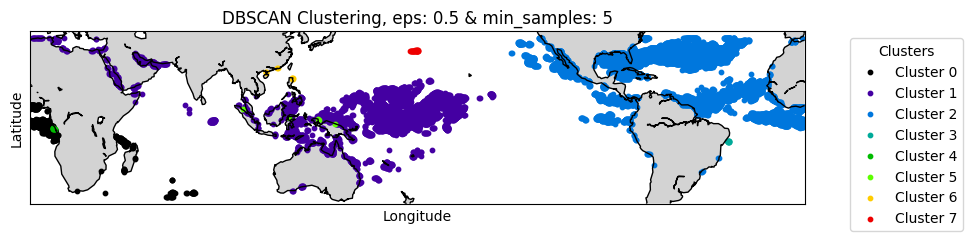

<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


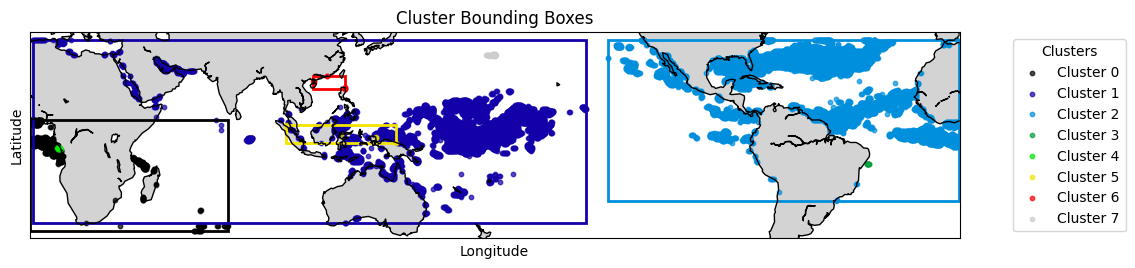

[0, 1, 2, 3, 4, 5, 6, 7]


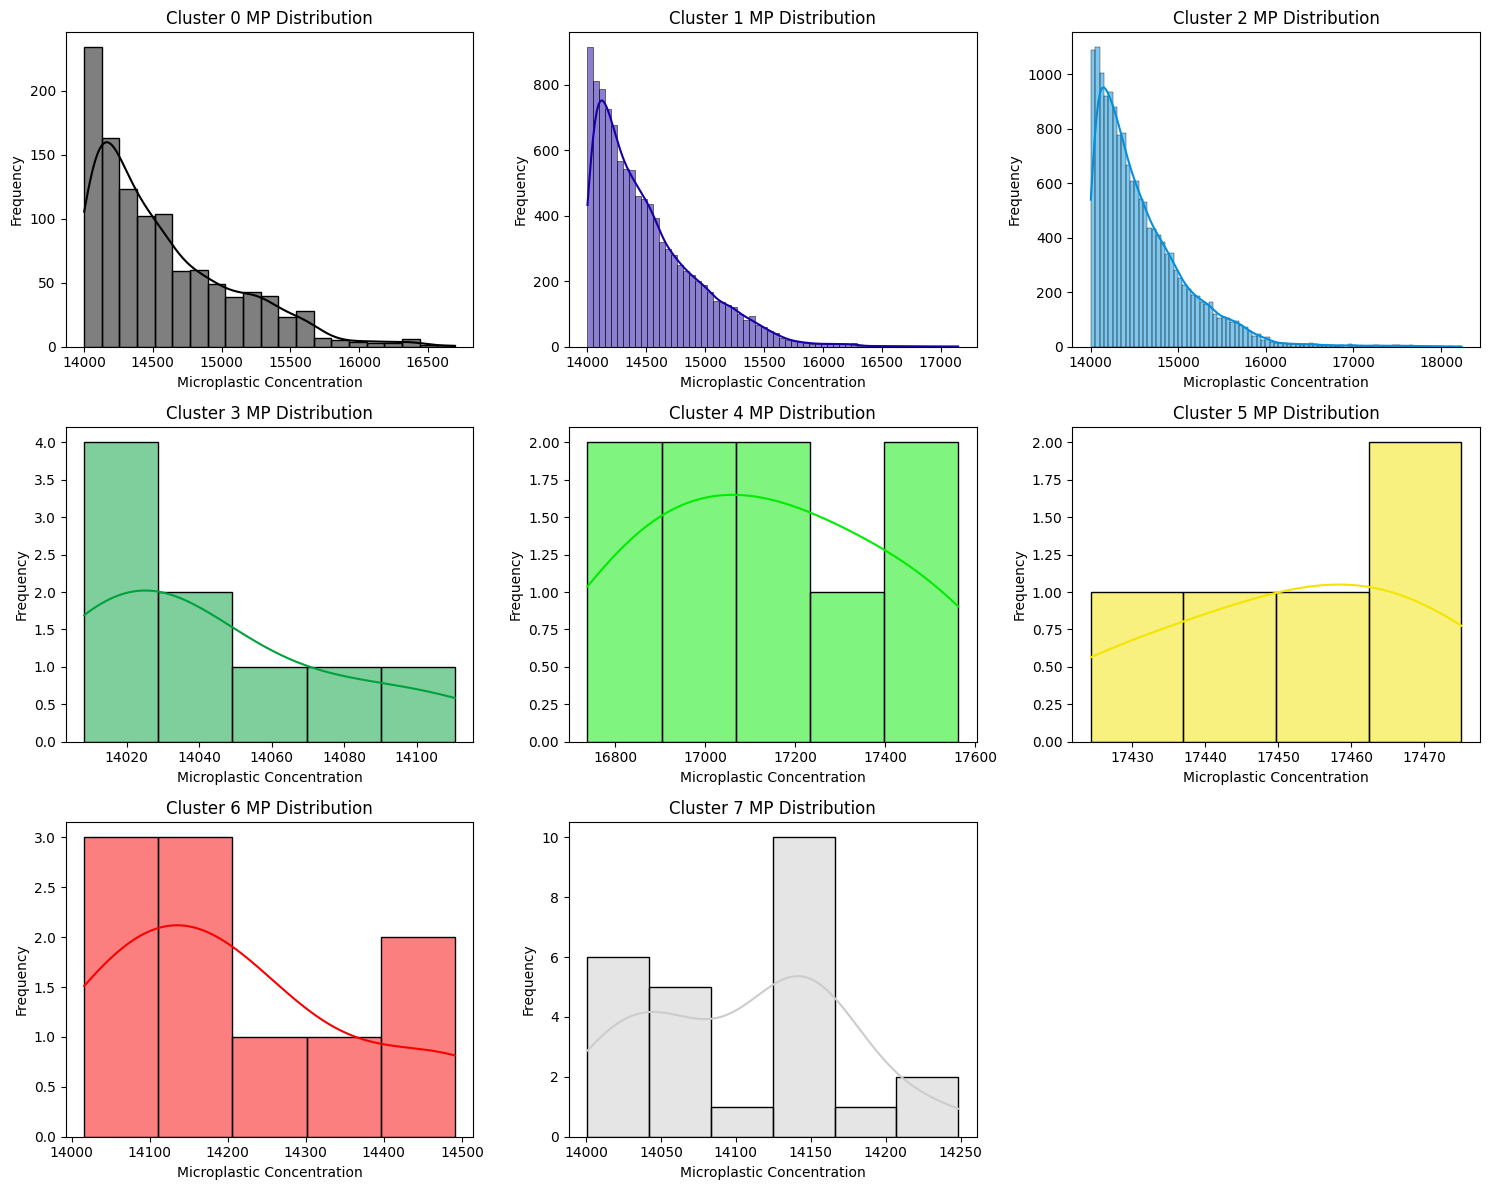

In [ ]:
dbscan(df_filtered, 0.5, 5)
bounding_boxes(df_filtered)
histogram(df_filtered)

In [ ]:

def analyze_nc_file(file_path, threshold, eps, min_samples):
    print(f"Loading data from {file_path}...")
    dataset = nc.Dataset(file_path)

    # Extract relevant variables (modify based on actual variable names in your dataset)
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    mp_conc = dataset.variables['mp_concentration'][:]
    mp_conc_squz = np.squeeze(mp_conc)

    # Convert to a DataFrame
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
    df = pd.DataFrame({
        "lat": lat_grid.flatten(),
        "lon": lon_grid.flatten(),
        "mp_conc": mp_conc_squz.flatten()
    })

    # Handle Missing Data
    df = df.dropna()
    df_filtered = df[df['mp_conc'] > threshold].copy()

    # Standardize Data
    scaler = StandardScaler()
    X = scaler.fit_transform(df_filtered[['lat', 'lon', 'mp_conc']])

    # Run DBSCAN Clustering
    print("Running DBSCAN Clustering...")
    dbscan(df_filtered, eps, min_samples)

    # Visualize Cluster Bounding Boxes
    print("Visualizing Cluster Bounding Boxes...")
    bounding_boxes(df_filtered)

    # Plot Microplastic Concentration Histogram
    print("Plotting Histogram of Microplastic Concentration...")
    histogram(df_filtered)

    print("\n✅ Analysis Complete!")



Loading data from 20181216.nc...
Running DBSCAN Clustering...


<ipython-input-116-fb7186593e2b>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


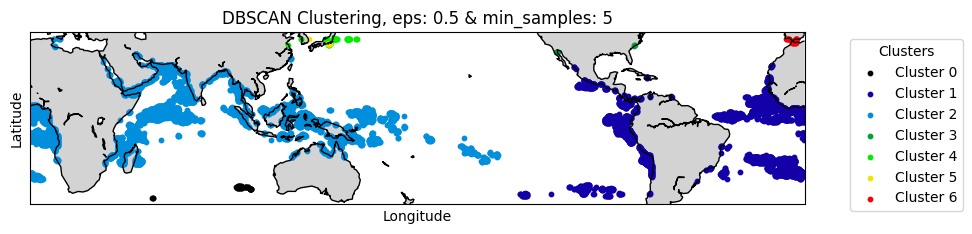

Visualizing Cluster Bounding Boxes...


<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


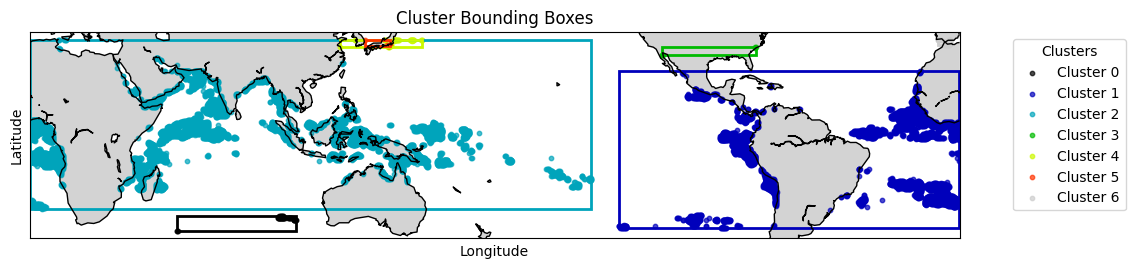

Plotting Histogram of Microplastic Concentration...
[0, 1, 2, 3, 4, 5, 6]


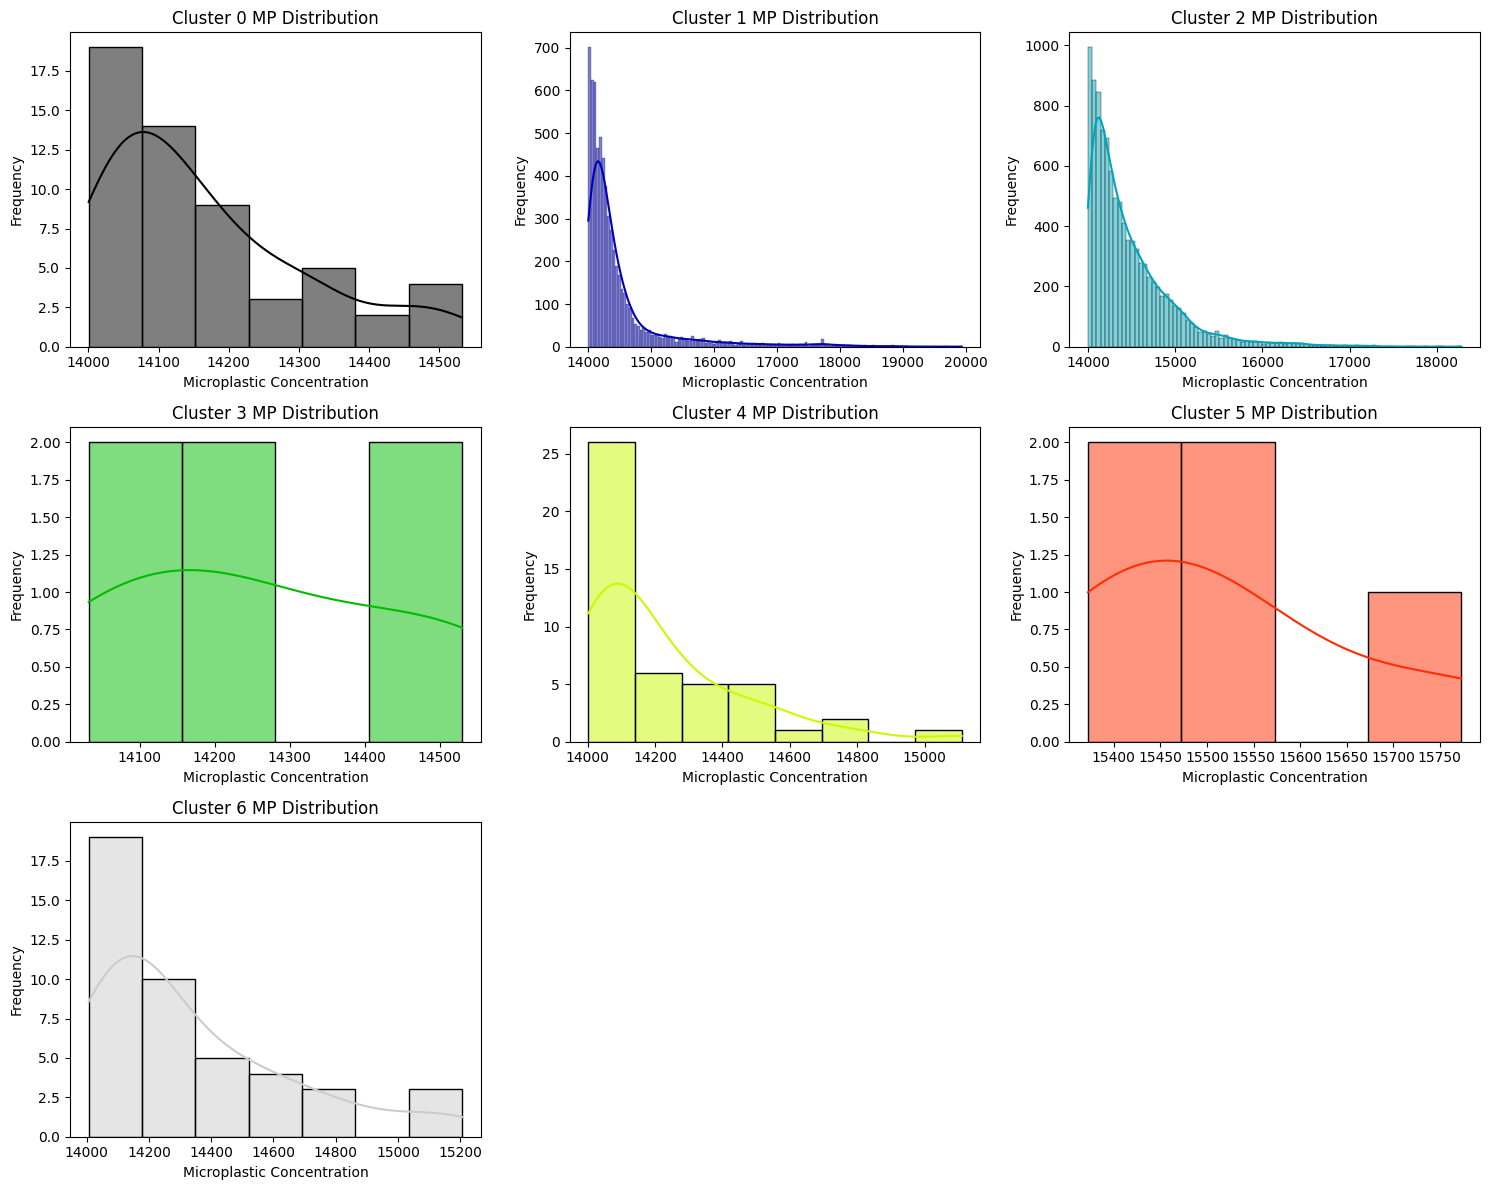


✅ Analysis Complete!


In [ ]:
# Example Usage
analyze_nc_file("20181216.nc", 14000, eps=0.5, min_samples=5)

Loading data from 20180816.nc...
Running DBSCAN Clustering...


<ipython-input-116-fb7186593e2b>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data['lon'], cluster_data['lat'], c=color(cluster), label=f'Cluster {cluster}', s=10)


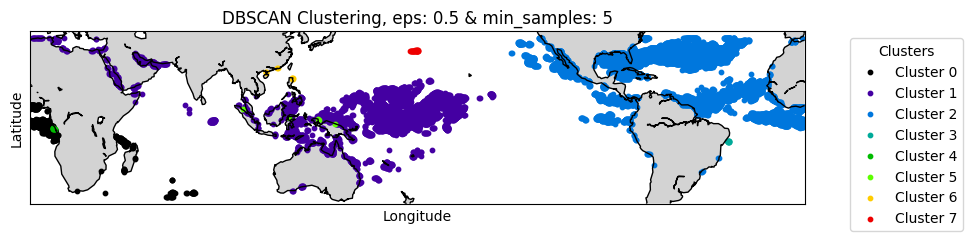

Visualizing Cluster Bounding Boxes...


<ipython-input-67-9e936e7f0f01>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=10, alpha=0.7, c=cluster_colors[cluster])


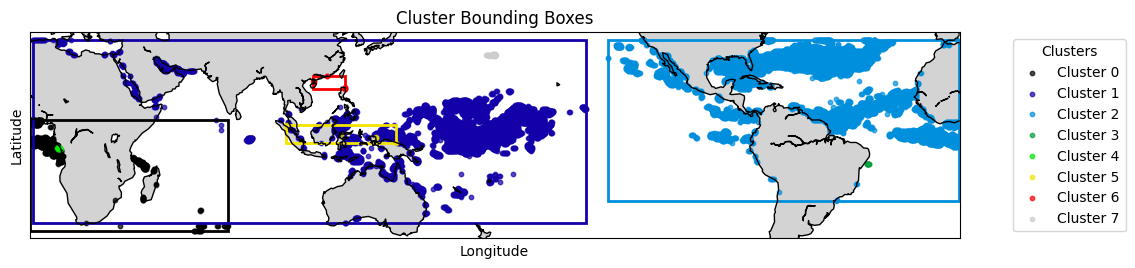

Plotting Histogram of Microplastic Concentration...
[0, 1, 2, 3, 4, 5, 6, 7]


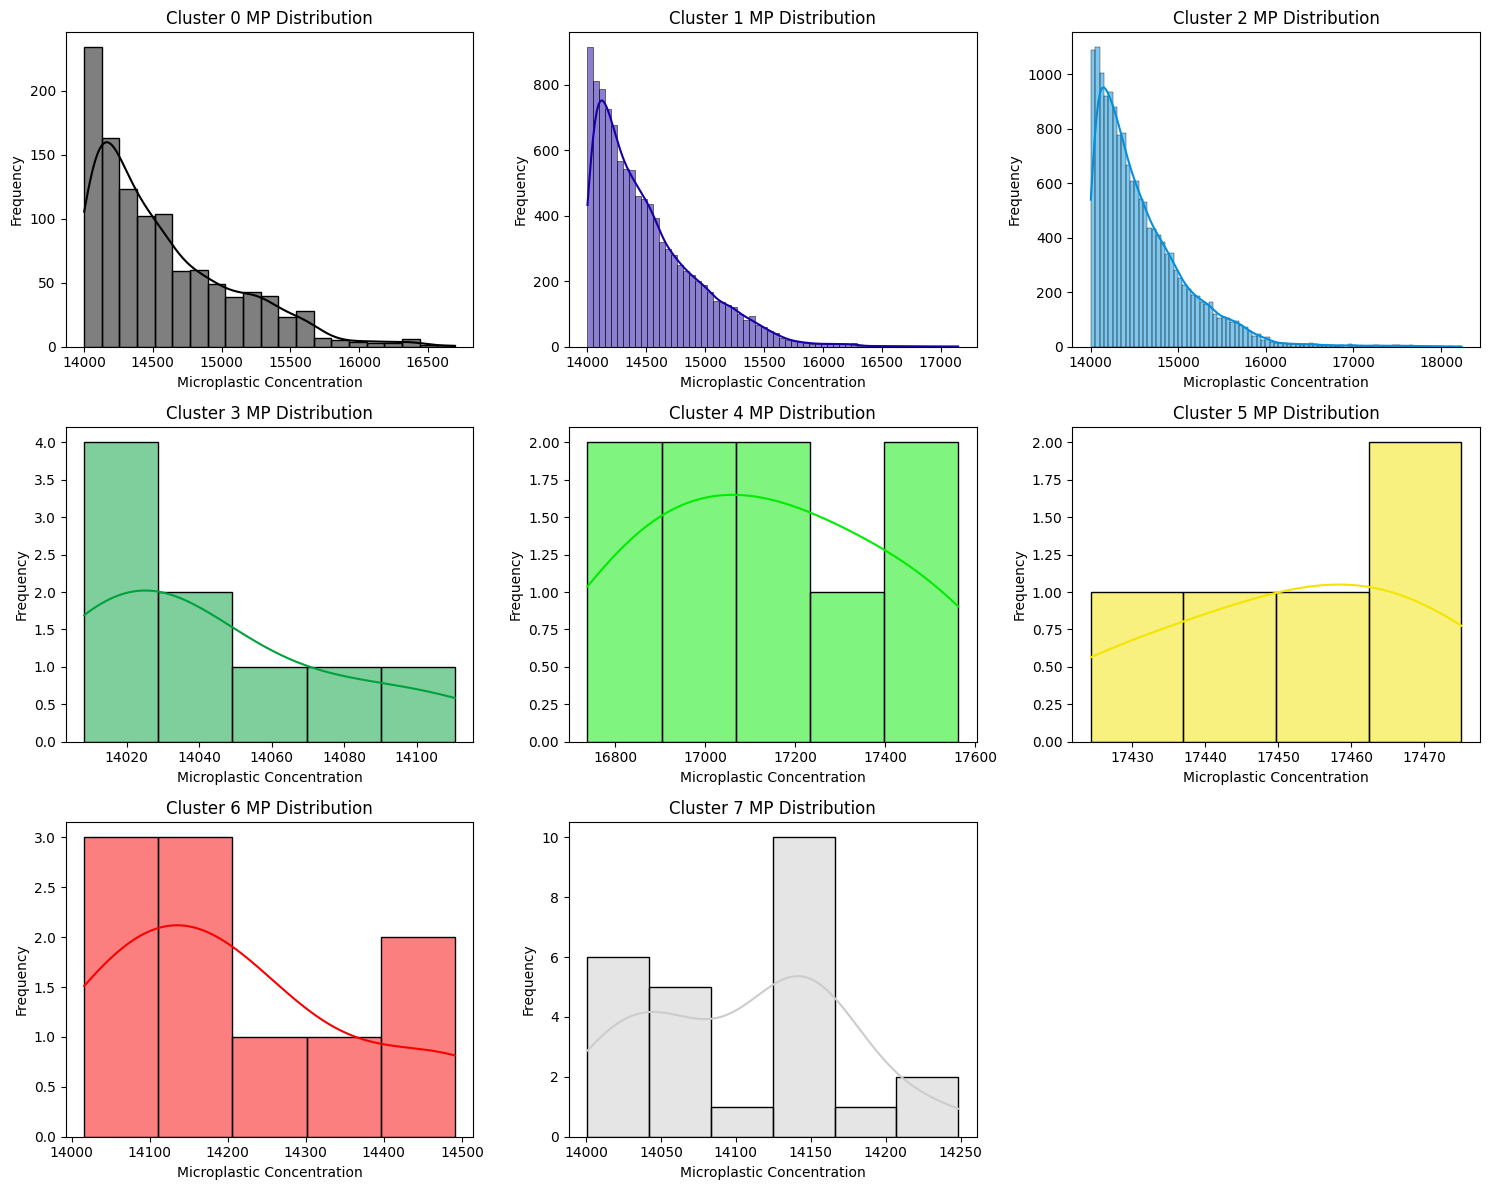


✅ Analysis Complete!


In [ ]:
analyze_nc_file("20180816.nc", 14000, eps=0.5, min_samples=5)